
# Big's Backyard Ultra
## Load the various utility libraries to setup the notebook

In [1]:

from datetime import datetime, timedelta
from pandas import DataFrame
from peakutils.plot import plot as pplot
from scipy.optimize import fsolve, curve_fit
import humanize, peakutils, re
import matplotlib.pyplot as plt
import numpy as np
import os.path as osp
import pandas as pd

# Load notebook utilities and reuglify print
import sys
sys.path.insert(1, osp.abspath('../py'))
from notebook_utils import NotebookUtilities
nu = NotebookUtilities(
    data_folder_path=osp.abspath('../data'),
    saves_folder_path=osp.abspath('../saves')
)
%pprint

Pretty printing has been turned OFF



## Simple functions

In [2]:

def get_single_runner_rest_times_data_frame(table_path, runner_name):
    rest_times_df = nu.get_page_tables(table_path, verbose=False)[0]
    rest_times_df['Rest Time'] = rest_times_df['Rest Time'].map(lambda time_string: datetime.strptime(time_string, '%M:%S'))
    rest_times_df['Rest Time'] = rest_times_df['Rest Time'].map(lambda time_obj: int(time_obj.minute*60 + time_obj.second))
    rest_times_df['runner_name'] = runner_name
    
    return rest_times_df

In [3]:

def show_rest_time_line_plot(rest_times_df, runner_name, peaks_count=2, verbose=False):
    mask_series = (rest_times_df.runner_name == runner_name) & ~rest_times_df['#'].isnull() & ~rest_times_df['Rest Time'].isnull()
    df = rest_times_df[mask_series]
    x = df['#'].values
    y = df['Rest Time'].values
    title=f'Rest Time of {runner_name} by Lap Number'
    
    # Do some minimal amount of "hill climbing" to optimize the parameters
    is_found = False
    for thres in np.linspace(0.05, 5, 100):
        if is_found: break
        for min_dist in np.linspace(3, 300, 100):
            if is_found: break
            indexes_list = peakutils.indexes(y, thres=thres, min_dist=min_dist)
            if (len(indexes_list) == peaks_count):
                if verbose: print(f'indexes_list = peakutils.indexes(y, thres={thres}, min_dist={min_dist}) = {indexes_list}')
                is_found = True
    
    # Create the figure and subplot
    fig, ax = plt.subplots(figsize=(18, 18/nu.twitter_aspect_ratio))
    df.plot(x='#', y='Rest Time', ax=ax)

    # Humanize y tick labels
    yticklabels_list = []
    for text_obj in ax.get_yticklabels():
        text_obj.set_text(humanize.precisedelta(timedelta(seconds=text_obj.get_position()[1])).replace(', ', ',\n').replace(' and ', ' and\n'))
        yticklabels_list.append(text_obj)
    ax.set_yticklabels(yticklabels_list)

    # Set the title and labels
    ax.set_title(title)
    ax.set_xlabel('Lap #')
    ax.set_ylabel('Time spent at Rest')
    ax.legend(loc='lower right')

    # Add the annotations for the peaks
    indexes_list = peakutils.indexes(y, thres=thres, min_dist=min_dist)
    if verbose:
        print(x)
        print(y)
        print(x[indexes_list])
        print(y[indexes_list])
    for i, (laps, seconds) in enumerate(zip(x[indexes_list], y[indexes_list])):
        if verbose: print(laps, seconds)
        annotation = plt.annotate(f'{humanize.ordinal(i+2)} Wind', xy=(laps, seconds), xytext=(laps, seconds+10), xycoords='data', ha='center');

In [4]:

def show_rolling_rest_time_line_plot(rest_times_df, runner_names_list, window_int=2, peaks_count=None, verbose=False):
    title=f'Rest Time of {nu.conjunctify_nouns(runner_names_list)} by {window_int} Lap Simple Moving Average'
    columns_list = ['#', 'Rest Time']
    
    # Create the figure and subplot
    fig, ax = plt.subplots(figsize=(18, 18/nu.twitter_aspect_ratio))
    fig.tight_layout()
    
    for runner_name in runner_names_list:
        if verbose: print(f'\n{runner_name}')
        mask_series = (rest_times_df.runner_name == runner_name) & ~rest_times_df['#'].isnull() & ~rest_times_df['Rest Time'].isnull()
        df = rest_times_df[mask_series][columns_list].rolling(window_int).mean()
        mask_series = ~df['#'].isnull() & ~df['Rest Time'].isnull()
        x = df[mask_series]['#'].values
        y = df[mask_series]['Rest Time'].values
        if np.size(y) > 0:
            df.plot(x='#', y='Rest Time', ax=ax, label=runner_name)
            if (peaks_count is not None) and (peaks_count > 0):
                
                # Do some minimal amount of "hill climbing" to optimize the parameters
                is_found = False
                for thres in np.linspace(0.05, 5, 100):
                    if is_found: break
                    for min_dist in np.linspace(3, 300, 100):
                        if is_found: break
                        indexes_list = peakutils.indexes(y, thres=thres, min_dist=min_dist)
                        if (len(indexes_list) == peaks_count):
                            if verbose: print(f'indexes_list = peakutils.indexes(y, thres={thres}, min_dist={min_dist}) = {indexes_list}')
                            is_found = True
                
                # Add the annotations for the peaks
                indexes_list = peakutils.indexes(y, thres=thres, min_dist=min_dist)
                if verbose:
                    print(x)
                    print(y)
                    print(x[indexes_list])
                    print(y[indexes_list])
                if not np.all(np.isnan(indexes_list)):
                    for i, (laps, seconds) in enumerate(zip(x[indexes_list], y[indexes_list])):
                        if verbose: print(laps, seconds)
                        annotation = plt.annotate(runner_name, xy=(laps, seconds), xytext=(laps, seconds+10), xycoords='data', ha='center')
                        break
    
    # Humanize y tick labels
    yticklabels_list = []
    for text_obj in ax.get_yticklabels():
        text_obj.set_text(humanize.precisedelta(timedelta(seconds=text_obj.get_position()[1])).replace(', ', ',\n').replace(' and ', ' and\n'))
        yticklabels_list.append(text_obj)
    ax.set_yticklabels(yticklabels_list)

    # Set the title and labels
    ax.set_title(title)
    ax.set_xlabel(f'{window_int} Lap Simple Moving Average')
    ax.set_ylabel('Time spent at Rest')
    ax.legend(title='Runner Name');

In [5]:

def get_r_squared_string(xdata, ydata, prefix_str=''):
    
    # Get r squared value
    inf_nan_mask = nu.get_inf_nan_mask(xdata.tolist(), ydata.tolist())
    from scipy.stats import pearsonr
    pearsonr_tuple = pearsonr(xdata[inf_nan_mask], ydata[inf_nan_mask])
    pearson_r = pearsonr_tuple[0]
    pearsonr_statement = str('%.2f' % pearson_r)
    coefficient_of_determination_statement = str('%.2f' % pearson_r**2)
    p_value = pearsonr_tuple[1]
    
    if p_value < 0.0001: pvalue_statement = '<0.0001'
    else: pvalue_statement = '=' + str('%.4f' % p_value)
    
    s_str = prefix_str + f': $r^2=' + coefficient_of_determination_statement + ',\ p' + pvalue_statement + '$'
    
    return s_str


## Clean and preprocess the homepage dataset

In [6]:

if nu.pickle_exists('backyard_ultra2023_homepage_df'): homepage_df = nu.load_object('backyard_ultra2023_homepage_df')

# Go to https://my.raceresult.com/266852/#0_B3DC1F, inspect page, copy the OuterHTML of the table
else:
    df = nu.get_page_tables(r'C:\Users\daveb\Downloads\homepage.html', verbose=False)[0].dropna(axis='columns', how='all')
    homepage_df = DataFrame([])
    for ((even_row_index, even_row_series), (odd_row_index, odd_row_series)) in zip(df.iloc[::2].iterrows(), df.iloc[1::2].iterrows()):
        even_row = even_row_series.to_frame().T.reset_index(drop=True)
        even_row.columns = [level0 for (level0, level1) in even_row.columns]

        odd_row = odd_row_series.to_frame().T.reset_index(drop=True)
        odd_row.columns = [level1 for (level0, level1) in odd_row.columns]
        odd_row = odd_row.dropna(axis='columns', how='all')
        odd_row.columns = ['Fast Loop Hour#', 'Slow Loop Hour#']

        row_df = pd.concat([even_row, odd_row], axis='columns')
        homepage_df = pd.concat([homepage_df, row_df], axis='index')
    homepage_df = homepage_df.dropna(axis='columns', how='all')
    nu.store_objects(backyard_ultra2023_homepage_df=homepage_df)

In [7]:

homepage_df.sort_values(['Laps', 'Slow Loop'], ascending=[False, True])

,Place,Bib,Name,Gender,Age,City,State,Last Loop,Fast Loop,Avg Loop,Slow Loop,Laps,Miles,RaceTime,Fast Loop Hour#,Slow Loop Hour#
0,1,5.0,Harvey Lewis,M,47.0,Cincinnati,OH,47:31,37:51,52:22,56:54,108.0,450.0,94:16:36,37,59
0,DNC,24.0,Ihor Verys,M,29.0,Chilliwack,BC,52:31,44:56,50:52,55:29,107.0,445.83,90:44:04,66,57
0,RTC,32.0,Bartosz Fudali,M,35.0,Wolsztyn,POL,53:25,32:42,46:51,54:12,103.0,429.16,80:26:55,13,92
0,DNC,13.0,Terumichi Morishita,M,43.0,Toyota City,JPN,58:40,38:11,48:36,58:40,101.0,420.83,81:50:09,16,101
0,OVER,2.0,Merijn Geerts,M,49.0,Wilsele,BEL,55:50,39:26,50:00,56:52,100.0,416.66,83:20:55,24,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,DNC,46.0,Philippe Pollesel,M,53.0,Pomport,FRA,59:31,49:15,53:42,59:31,25.0,104.16,22:22:35,13,25
0,OVER,71.0,Van Da Bui,M,45.0,Ho Chi Minh,VNM,45:47,36:25,44:30,51:38,24.0,100.0,17:48:18,2,11
0,RTC,72.0,Rene Romualdo Cunha,M,44.0,Santa Cruz Do Capibaribe,BRA,48:27,38:33,42:40,48:27,23.0,95.83,16:21:39,14,23
0,OVER,47.0,Fabrice Puaud,M,55.0,Mignaloux-Beauvoir,FRA,56:58,44:00,50:18,56:58,10.0,41.66,8:23:05,3,10



## Aggregate the suffered-enough dataset

In [30]:

runner_count = homepage_df.Name.unique().shape[0]
max_lap = int(homepage_df.Laps.max())
suffered_enough_count = 0
rows_list = []
for lap_number in range(1, max_lap+1):
    mask_series = (homepage_df.Laps == lap_number) & (homepage_df.Place != '1')
    suffered_enough_count += homepage_df[mask_series].shape[0]
    if mask_series.any():
        row_dict = {}
        row_dict['lap_number'] = lap_number
        row_dict['suffered_enough_count'] = suffered_enough_count
        rows_list.append(row_dict)
suffered_enough_df = DataFrame(rows_list).set_index('lap_number')


## Visualize the interesting aspects

In [31]:

# Get the elbow of the line
idx = suffered_enough_df.reset_index(drop=False).lap_number.diff().sort_values(ascending=False).index[0]
jump_lap = suffered_enough_df.iloc[idx].name

# Filter out every lap below the elbow
mask_series = (suffered_enough_df.index >= jump_lap)
filtered_df = suffered_enough_df[mask_series]

# Get lap numbers and suffered enough count values
lap_numbers = filtered_df.index.values
X0 = lap_numbers[0]  # Initial value of lap_numbers
suffered_enough_counts = filtered_df.suffered_enough_count.values

# Fit a line to the data points
coefficients = np.polyfit(lap_numbers, suffered_enough_counts, 1)

# Create a line using the fitted coefficients
line_fit = np.polyval(coefficients, lap_numbers)

# Create a smoother x range for plotting the fitted curve
smoothx = np.linspace(X0, lap_numbers[-1], 20)

In [32]:

# Define the exponential decay function
exp_decay = lambda x, y0, yp, k: y0 + (yp - y0) * (1 - np.exp(-k * (x - X0)))

# Initial guess for the parameters of the exponential decay curve
# The parameters of the exponential decay function have the following meanings:
# guess_y0: The y-intercept of the exponential decay curve.
# guess_yp: The initial value of the exponential decay curve.
# guess_k: The decay rate of the exponential decay curve.
guess_y0, guess_yp, guess_k = 3.805529670180681, 130.70847623668885, 0.0105173833

# Fit the exponential decay function to the data using curve fitting
params, cov = curve_fit(exp_decay, lap_numbers, suffered_enough_counts, p0=[guess_y0, guess_yp, guess_k])

# Extract the parameters of the fitted exponential decay curve
y0, yp, k = params

# Print the fitted parameters for inspection
print(f'guess_y0, guess_yp, guess_k = {y0}, {yp}, {k:,.10f}\n')

# Define a function to evaluate the fitted exponential decay curve at any lap number
exponential_decay_fit = lambda x: y0 + (yp - y0) * (1 - np.exp(-k * (x - X0)))

# Define the function to find the root of (exponential_decay_fit - runner_count)
def equation(lap_number, runner_count): return exponential_decay_fit(lap_number) - runner_count

guess_y0, guess_yp, guess_k = 3.153554197710506, 108.39341197127952, 0.0136867166



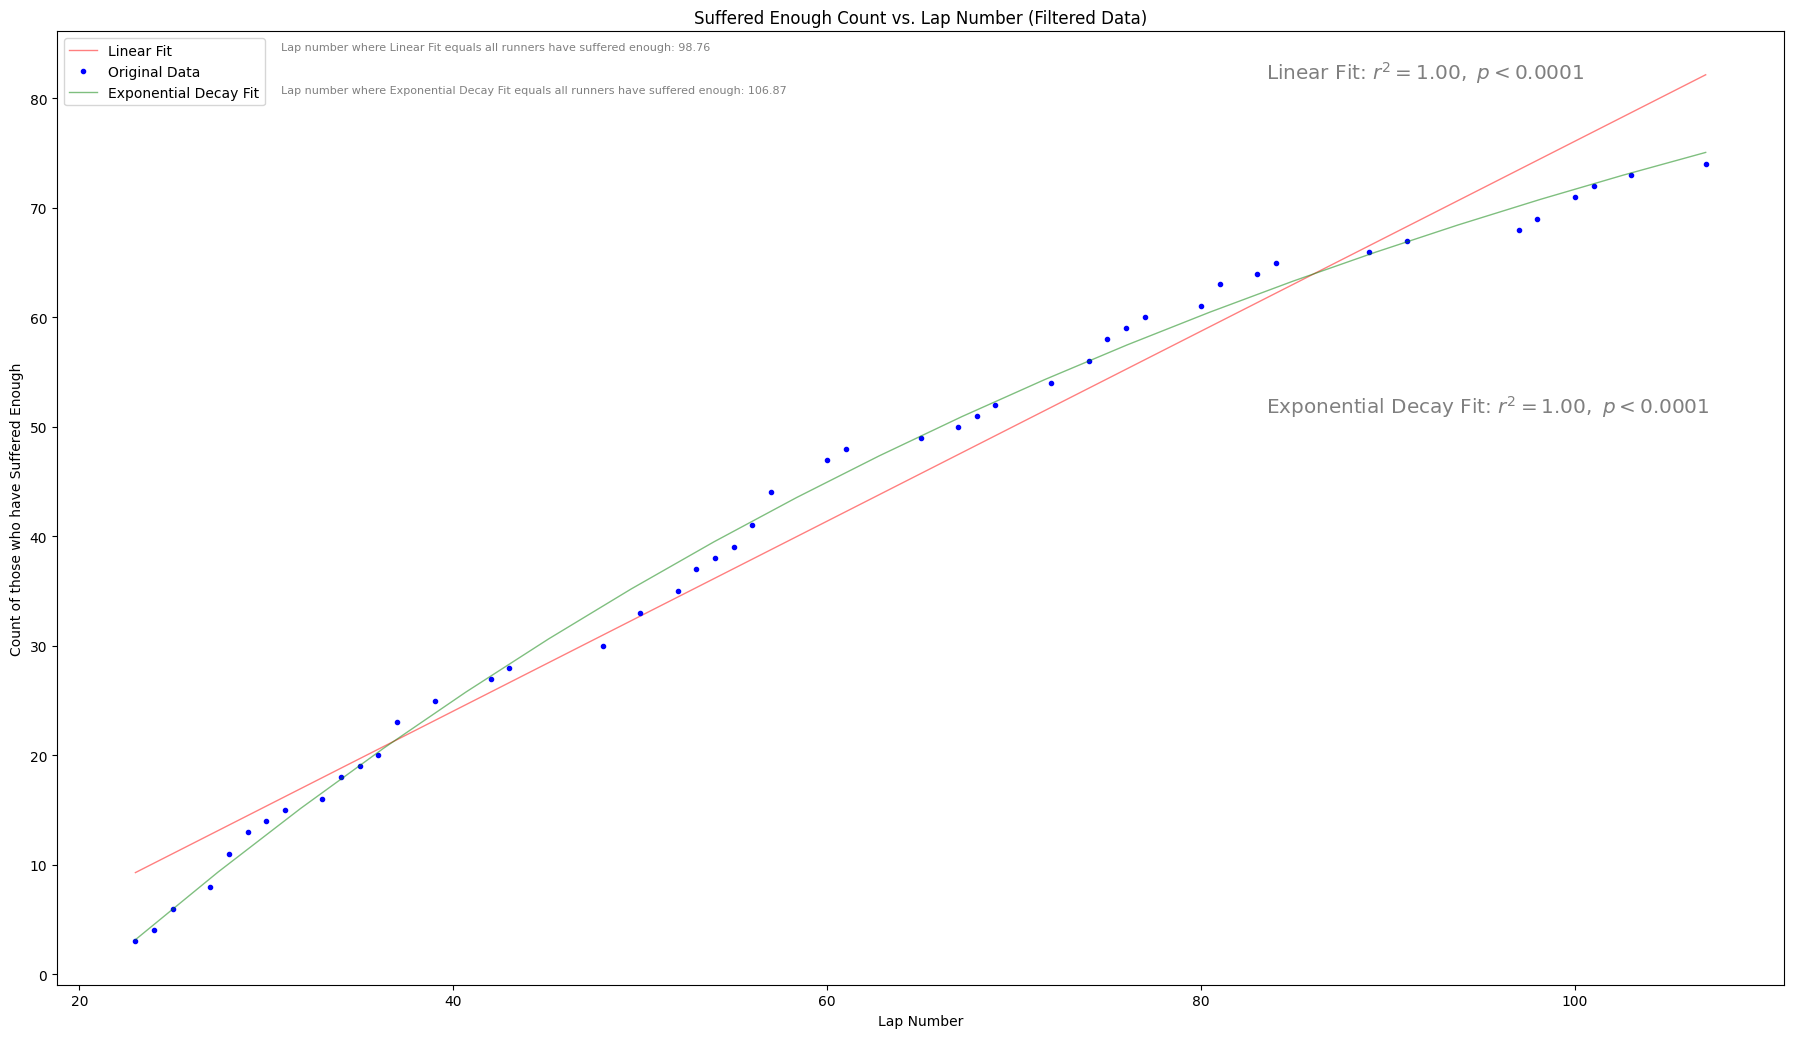

In [33]:

# Create the figure and subplot
fig, ax = plt.subplots(figsize=(18, 18/nu.twitter_aspect_ratio))
fig.tight_layout()

# Plot the fitted line
ax.plot(lap_numbers, line_fit, color='red', linewidth=1, alpha=0.5, label='Linear Fit')

# Plot the original data points and the best-fit curve
ax.plot(lap_numbers, suffered_enough_counts, 'b.', label='Original Data')  # Plot data points
ax.plot(smoothx, exponential_decay_fit(smoothx), 'g-', label='Exponential Decay Fit', linewidth=1, alpha=0.5)  # Plot the fitted curve

# Set labels, legend, and title
ax.set_xlabel('Lap Number')
ax.set_ylabel('Count of those who have Suffered Enough')
ax.set_title('Suffered Enough Count vs. Lap Number (Filtered Data)')

# Show legend
ax.legend()

# Annotate the linear fit
s_str = get_r_squared_string(lap_numbers, line_fit, prefix_str=r'Linear Fit')
text_tuple = ax.text(0.7, 0.95, s_str, alpha=0.5, transform=ax.transAxes, fontsize='x-large')

# Solve the equation for lap number
lap_number = (runner_count - coefficients[1]) / coefficients[0]
text_tuple = ax.text(0.13, 0.98, f'Lap number where Linear Fit equals all runners have suffered enough: {lap_number:.2f}', alpha=0.5, transform=ax.transAxes, fontsize=8)

# Annotate the exponential fit
s_str = get_r_squared_string(lap_numbers, line_fit, prefix_str=r'Exponential Decay Fit')
text_tuple = ax.text(0.7, 0.6, s_str, alpha=0.5, transform=ax.transAxes, fontsize='x-large')

# Solve the equation for lap_number
lap_number_solution = fsolve(equation, x0=jump_lap, args=(runner_count))
text_tuple = ax.text(
    0.13, 0.935, f'Lap number where Exponential Decay Fit equals all runners have suffered enough: {lap_number_solution[0]:.2f}', alpha=0.5, transform=ax.transAxes, fontsize=8
)

# Show the plot
plt.show()

In [34]:

# Define the function to fit a sinusoidal curve on top of an exponential decay curve
sinusoidal_exponential_decay = lambda x, y0, yp, k, A, w, phi: y0 + (yp - y0) * (1 - np.exp(-k * (x - X0))) + A * np.sin(w * x + phi)

# Initial guess for the parameters of the sinusoidal exponential decay curve
# The parameters of the sinusoidal exponential decay function have the following meanings:
# guess_y0: The y-intercept of the exponential decay curve.
# guess_yp: The initial value of the exponential decay curve.
# guess_k: The decay rate of the exponential decay curve.
# guess_A: The amplitude of the sinusoidal component of the curve.
# guess_w: The frequency of the sinusoidal component of the curve, representing the number of times the curve oscillates per lap.
# guess_phi: The phase shift of the sinusoidal component of the curve.
guess_y0, guess_yp, guess_k, guess_A, guess_w, guess_phi = 3.0990694069603864, 107.9855880936907, 0.0136867166, -0.2730873624868345, 24.0, 34.646354788434614

# Fit the sinusoidal exponential decay function to the data using curve fitting
params, cov = curve_fit(sinusoidal_exponential_decay, lap_numbers, suffered_enough_counts, p0=[guess_y0, guess_yp, guess_k, guess_A, guess_w, guess_phi])

# Extract the parameters of the fitted sinusoidal exponential decay curve
y0, yp, k, A, w, phi = params

# Print the fitted parameters for inspection
print(f'guess_y0, guess_yp, guess_k, guess_A, guess_w, guess_phi = {y0}, {yp}, {k:,.10f}, {A}, {w}, {phi}\n')

# Define a function to evaluate the fitted sinusoidal exponential decay curve at any lap number
sinusoidal_exponential_decay_fit = lambda x: y0 + (yp - y0) * (1 - np.exp(-k * (x - X0))) + A * np.sin(w * x + phi)

# Define the function to find the root of (sinusoidal_exponential_decay_fit - runner_count)
def equation(lap_number, runner_count): return sinusoidal_exponential_decay_fit(lap_number) - runner_count

guess_y0, guess_yp, guess_k, guess_A, guess_w, guess_phi = 3.0616412356618437, 107.54805224986458, 0.0138633831, -0.46614581862641247, 24.161960750213865, 28.29394529813569



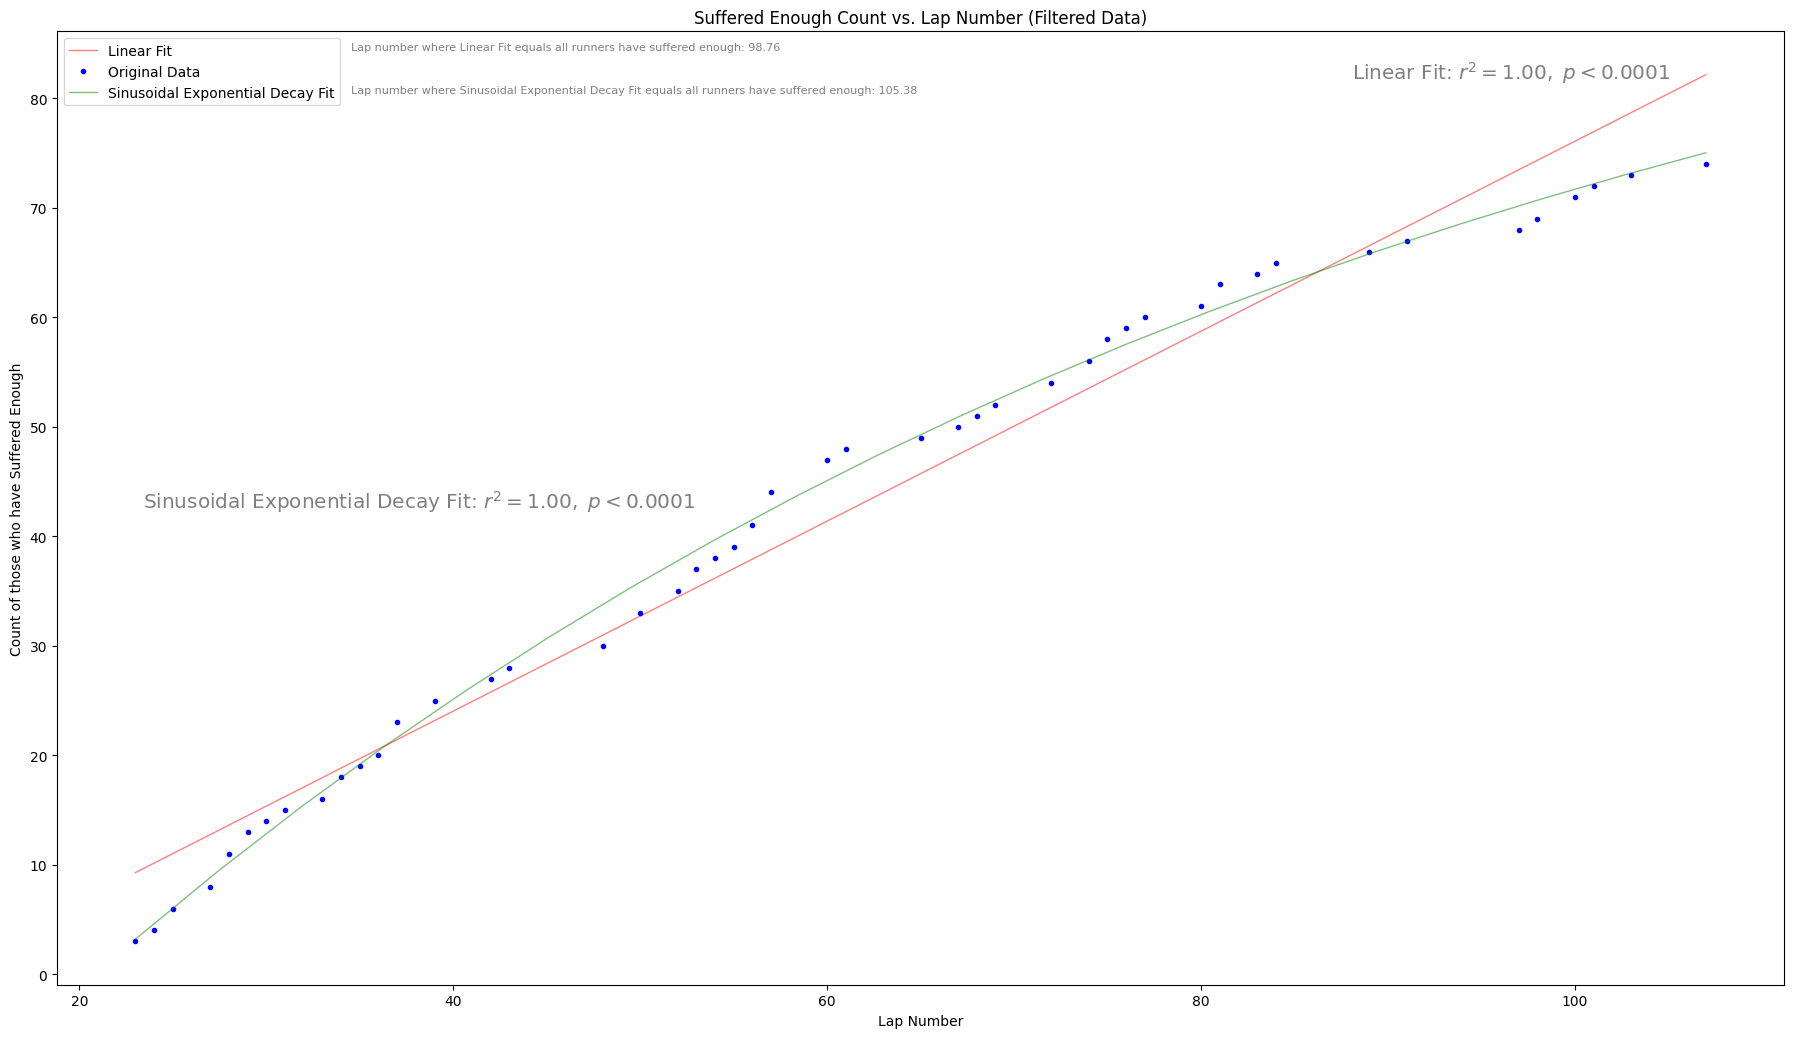

In [35]:

# Create the figure and subplot
fig, ax = plt.subplots(figsize=(18, 18/nu.twitter_aspect_ratio))
fig.tight_layout()

# Plot the fitted line
ax.plot(lap_numbers, line_fit, color='red', linewidth=1, alpha=0.5, label='Linear Fit')

# Plot the original data points and the best-fit curve
ax.plot(lap_numbers, suffered_enough_counts, 'b.', label='Original Data')  # Plot data points
ax.plot(smoothx, sinusoidal_exponential_decay_fit(smoothx), 'g-', label='Sinusoidal Exponential Decay Fit', linewidth=1, alpha=0.5)  # Plot the fitted curve

# Set labels, legend, and title
ax.set_xlabel('Lap Number')
ax.set_ylabel('Count of those who have Suffered Enough')
ax.set_title('Suffered Enough Count vs. Lap Number (Filtered Data)')

# Show legend
ax.legend()

# Annotate the linear fit
s_str = get_r_squared_string(lap_numbers, line_fit, prefix_str=r'Linear Fit')
text_tuple = ax.text(0.75, 0.95, s_str, alpha=0.5, transform=ax.transAxes, fontsize='x-large')

# Solve the equation for lap number
lap_number = (runner_count - coefficients[1]) / coefficients[0]
text_tuple = ax.text(0.17, 0.98, f'Lap number where Linear Fit equals all runners have suffered enough: {lap_number:.2f}', alpha=0.5, transform=ax.transAxes, fontsize=8)

# Annotate the sinusoidal exponential fit
s_str = get_r_squared_string(lap_numbers, line_fit, prefix_str=r'Sinusoidal Exponential Decay Fit')
text_tuple = ax.text(0.05, 0.5, s_str, alpha=0.5, transform=ax.transAxes, fontsize='x-large')

# Solve the equation for lap_number
lap_number_solution = fsolve(equation, x0=jump_lap, args=(runner_count))
text_tuple = ax.text(
    0.17, 0.935, f'Lap number where Sinusoidal Exponential Decay Fit equals all runners have suffered enough: {lap_number_solution[0]:.2f}', alpha=0.5, transform=ax.transAxes,
    fontsize=8
)

# Show the plot
plt.show()

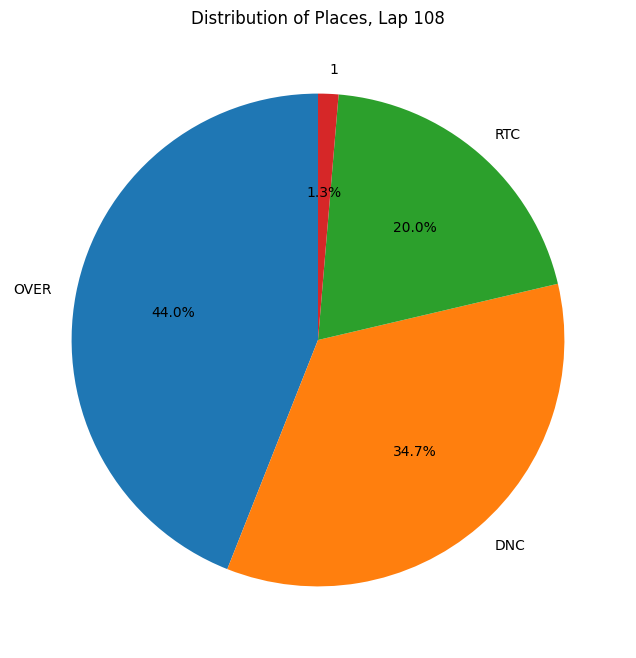

In [25]:

mark_series = ~homepage_df.Place.isnull()# & (homepage_df.Place != '1')

# Filter non-null and non-'1' values in the Place column
filtered_places = homepage_df[mark_series].Place

# Count the occurrences of each unique value
place_counts = filtered_places.value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(place_counts, labels=place_counts.index, autopct='%1.1f%%', startangle=90)
max_lap = int(homepage_df.Laps.max())
plt.title(f'Distribution of Places, Lap {max_lap}')
plt.show()

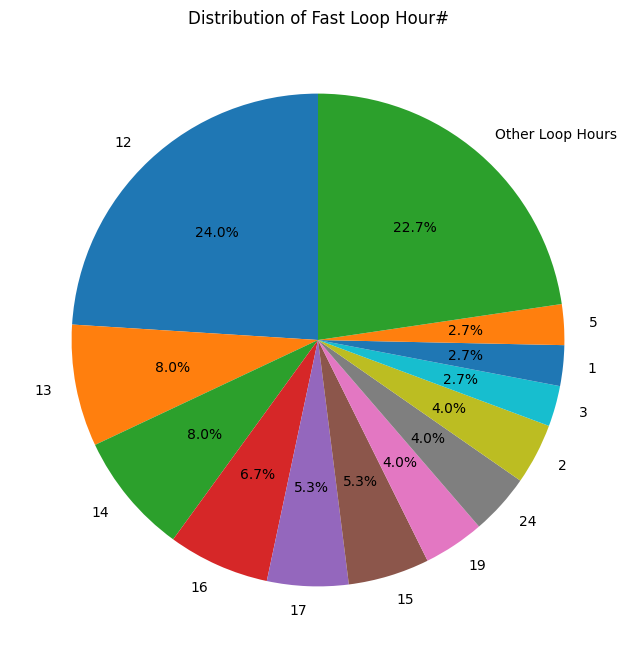

In [26]:

# Filter non-null values in the specified column
column_name = 'Fast Loop Hour#'
mark_series = ~homepage_df[column_name].isnull()  # Filter non-null values in the column
filtered_values = homepage_df[mark_series][column_name]

# Count the occurrences of each unique value
value_counts = filtered_values.value_counts()

# Group values with count equal to 1 into one slice
grouped_value_counts = value_counts[value_counts > 1]
grouped_value_counts['Other Loop Hours'] = value_counts[value_counts == 1].sum()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(grouped_value_counts, labels=grouped_value_counts.index, autopct='%1.1f%%', startangle=90)
plt.title(f'Distribution of {column_name}')
plt.show()

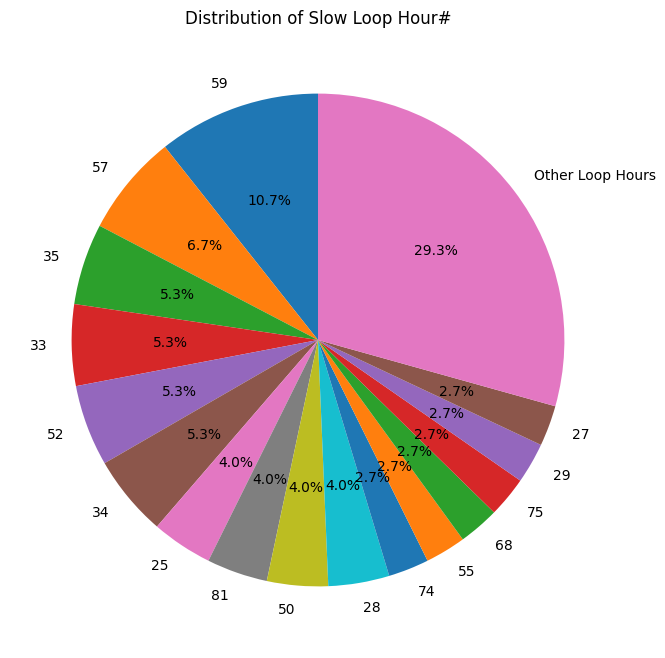

In [27]:

# Filter non-null values in the specified column
column_name = 'Slow Loop Hour#'
mark_series = ~homepage_df[column_name].isnull()  # Filter non-null values in the column
filtered_values = homepage_df[mark_series][column_name]

# Count the occurrences of each unique value
value_counts = filtered_values.value_counts()

# Group values with count equal to 1 into one slice
grouped_value_counts = value_counts[value_counts > 1]
grouped_value_counts['Other Loop Hours'] = value_counts[value_counts == 1].sum()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(grouped_value_counts, labels=grouped_value_counts.index, autopct='%1.1f%%', startangle=90)
plt.title(f'Distribution of {column_name}')
plt.show()


## Clean and preprocess the lap details dataset

In [10]:

if nu.pickle_exists('backyard_ultra2023_lapdetails_df'): rest_times_df = nu.load_object('backyard_ultra2023_lapdetails_df')

# Go to https://my.raceresult.com/266852/results#0_2C3B48, inspect the page, copy the OuterHTML of the table
else:
    lap_details_df = nu.get_page_tables(r'C:\Users\daveb\Downloads\lapdetails.html', verbose=False)[0]
    header_regex = re.compile(r'^\d+(\D+)(\d+)Laps$')
    laps_tuples_list = []
    for header, df in lap_details_df.groupby('Unnamed: 0'):
        match_obj = header_regex.search(header)
        if match_obj:
            runner_name = match_obj.group(1)
            laps_count = int(match_obj.group(2))
            idx = df.index.tolist()[0]
            # print(f'{idx} {runner_name} {laps_count} Laps')
            laps_tuple = (idx, runner_name, laps_count)
            laps_tuples_list.append(laps_tuple)
    laps_tuples_list = sorted(laps_tuples_list)
    rest_times_df = DataFrame([])
    for laps_tuple_previous, laps_tuple_next in zip(laps_tuples_list[:-1], laps_tuples_list[1:]):
        # print(laps_tuple_previous, laps_tuple_next)
        df = lap_details_df.iloc[laps_tuple_previous[0]+1: laps_tuple_next[0]].dropna(axis='columns', how='all').dropna(axis='index', how='all')
        df['runner_name'] = laps_tuple_previous[1]
        df['Rest Time'] = df['Rest Time'].map(lambda time_string: datetime.strptime(time_string, '%M:%S'))
        df['Rest Time'] = df['Rest Time'].map(lambda time_obj: int(time_obj.minute*60 + time_obj.second))
        df['#'] = df['#'].map(lambda x: int(str(x)))
        # display(df)
        rest_times_df = pd.concat(
            [rest_times_df, df], axis='index'
        )
    nu.store_objects(backyard_ultra2023_lapdetails_df=rest_times_df)

In [11]:

rest_times_df.sample(min(16, rest_times_df.shape[0])).dropna(axis='columns', how='all').T

,137,3245,1968,2197,2076,627,584,3158,3849,1877,2732,2503,1526,3484,1400,1256
#,35,63,59,64,51,62,19,52,3,67,29,49,3,36,32,21
Measurement,41:55:41,69:53:24,65:53:14,70:50:26,57:53:07,68:48:25,25:36:59,58:56:37,9:48:39,73:52:27,35:50:33,55:55:04,9:49:54,42:51:59,38:54:29,27:51:10
Lap Split,55:41,53:24,53:14,50:26,53:07,48:25,36:59,56:37,48:39,52:27,50:33,55:04,49:54,51:59,54:28,51:10
Rest Time,258,395,405,573,412,694,1380,202,680,452,566,295,605,480,331,529
runner_name,Merijn Geerts,Rodolfo RamÃ­rez,Akihiro Maeda,Kevin Sneyders,Reyes Satevo,Daiki Shibawaki,Daiki Shibawaki,Matthias Pelgrims,Angelika Huemer,Frank Gielen,Jon Asphjell,Levi Yoder,David Stoltenborg,Ben Nicholls,Tokimasa Hirata,Antonio Di Manno



## Visualize the interesting aspects

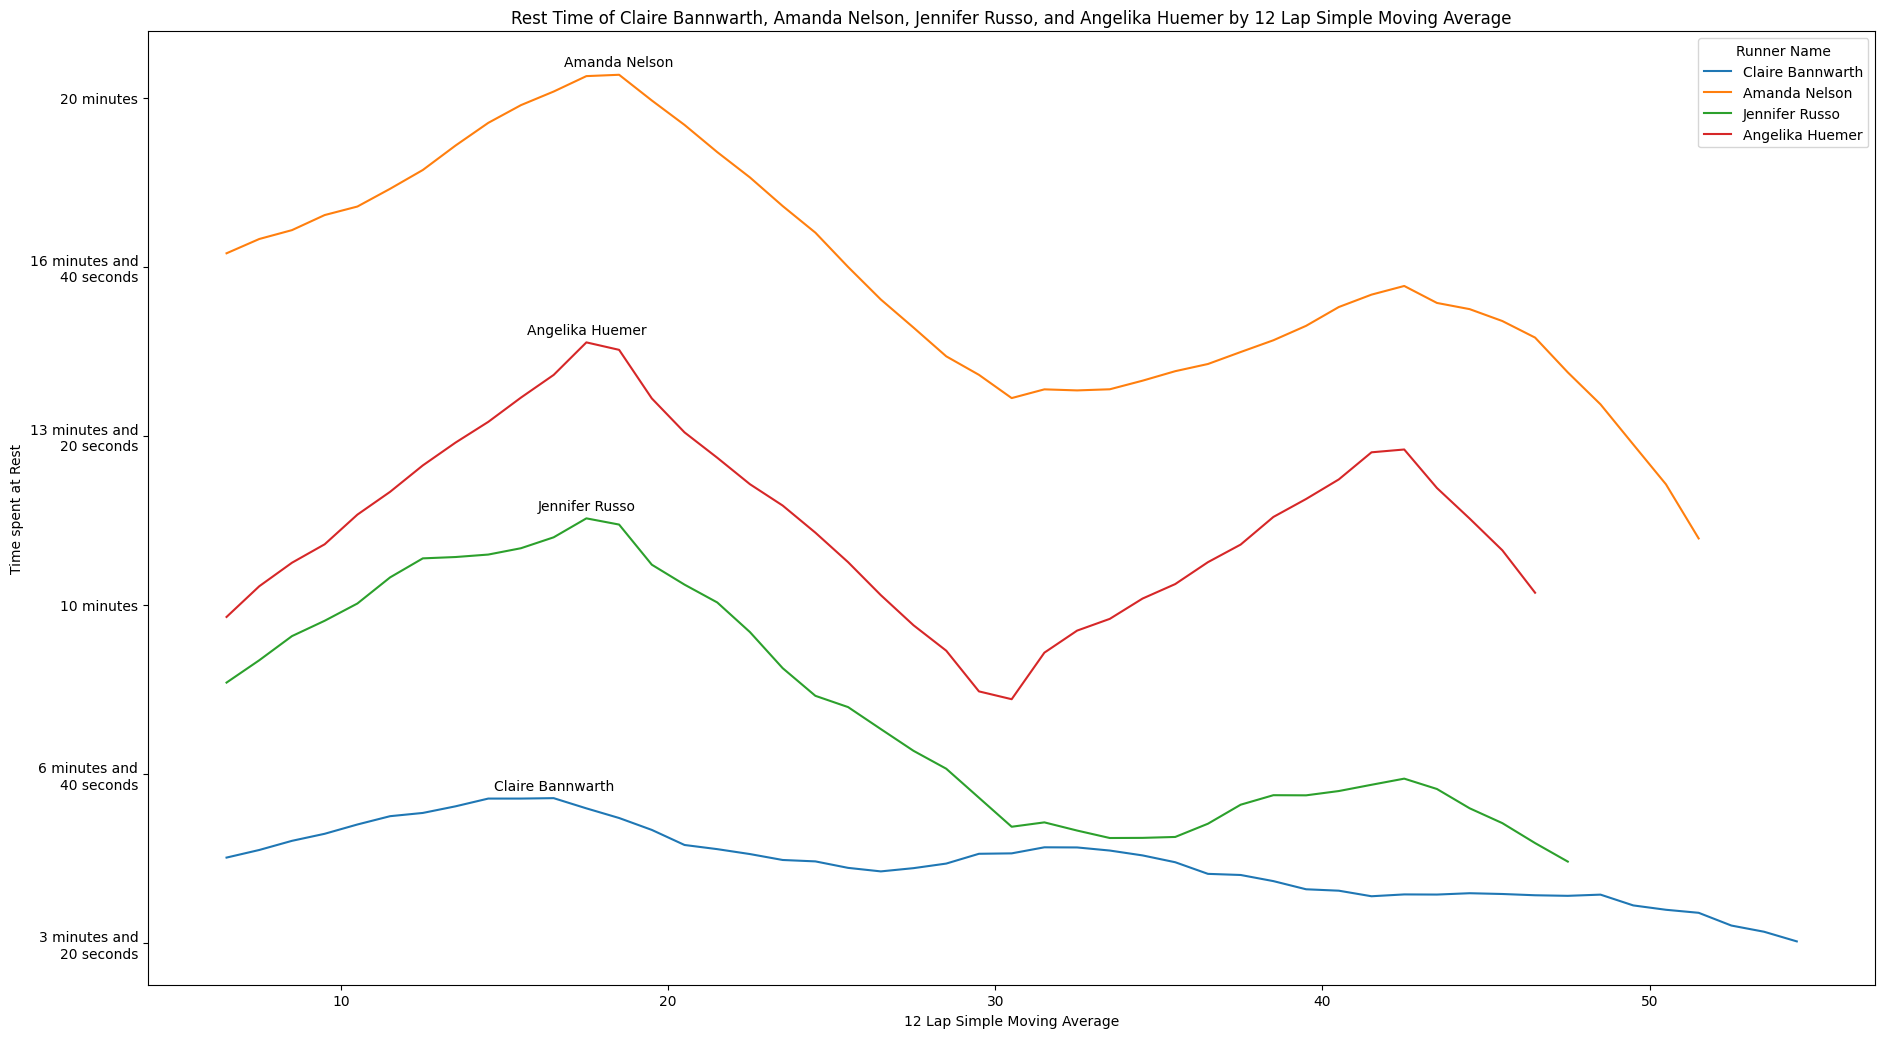

In [12]:

# Get all the female runners in one plot
match_series = (homepage_df.Gender == 'F')
runner_names_list = homepage_df[match_series].sort_values(['Laps', 'Slow Loop'], ascending=[False, True]).Name.tolist()
show_rolling_rest_time_line_plot(rest_times_df, runner_names_list, window_int=12, peaks_count=2, verbose=False)

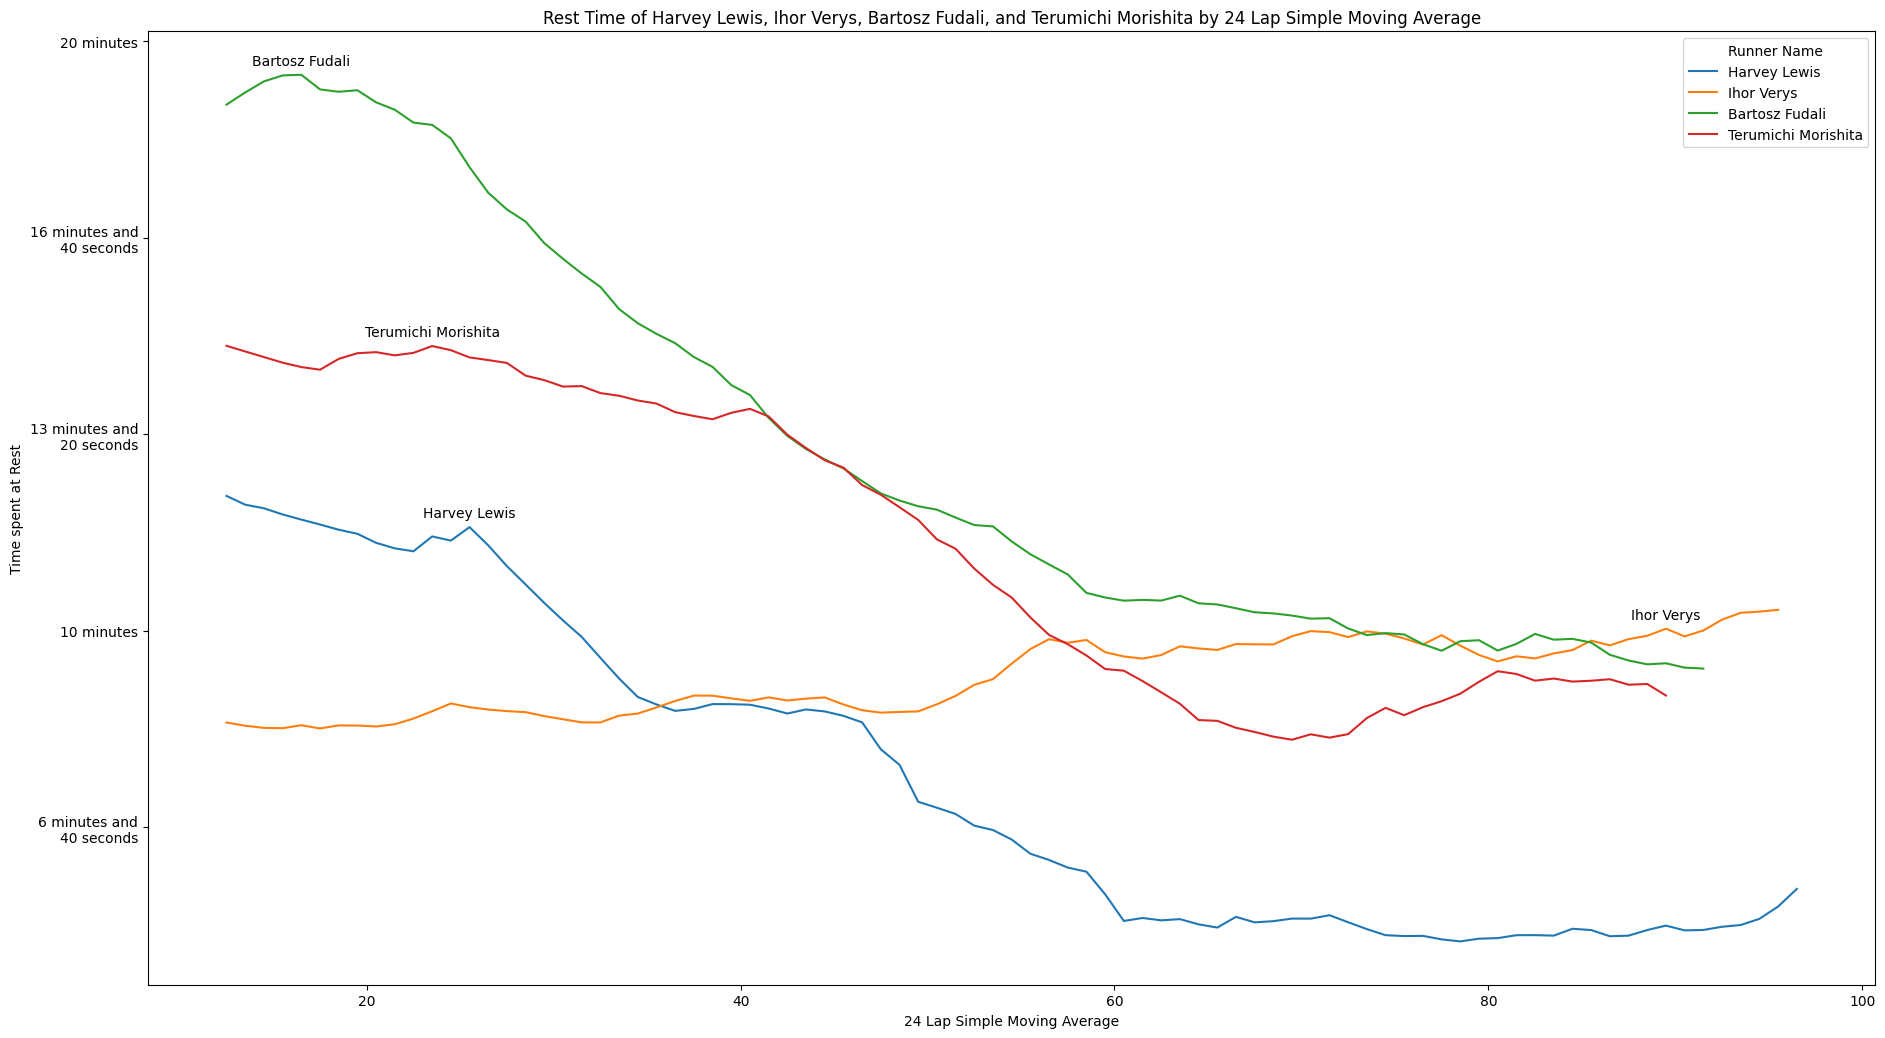

In [13]:

# max_lap = int(homepage_df.Laps.max())
# match_series = (homepage_df.Laps == max_lap)#[match_series]
runner_names_list = homepage_df.sort_values(['Laps', 'Slow Loop'], ascending=[False, True]).iloc[:4].Name.tolist()
show_rolling_rest_time_line_plot(rest_times_df, runner_names_list, window_int=24, peaks_count=1, verbose=False)

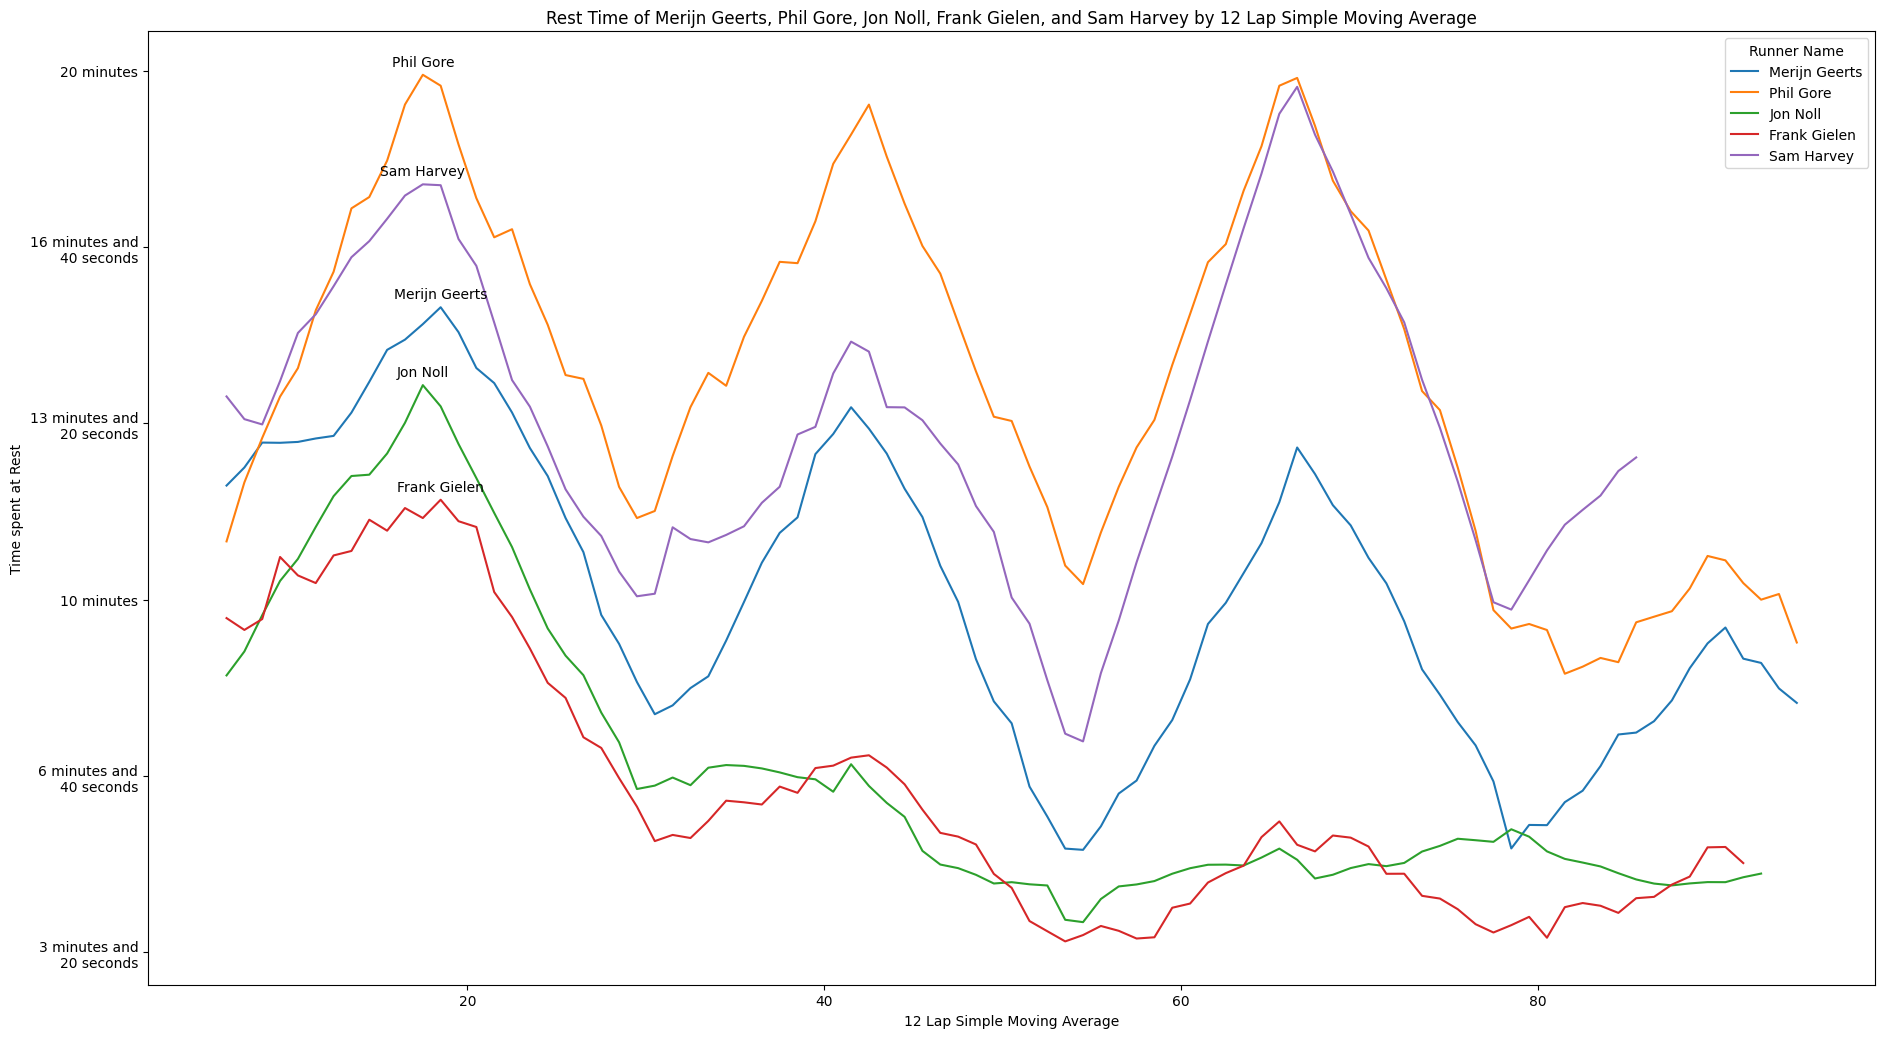

In [14]:

# max_lap = int(homepage_df.Laps.max())
# match_series = (homepage_df.Laps == max_lap)#[match_series]
runner_names_list = homepage_df.sort_values(['Laps', 'Slow Loop'], ascending=[False, True]).iloc[4:9].Name.tolist()
show_rolling_rest_time_line_plot(rest_times_df, runner_names_list, window_int=12, peaks_count=3, verbose=False)

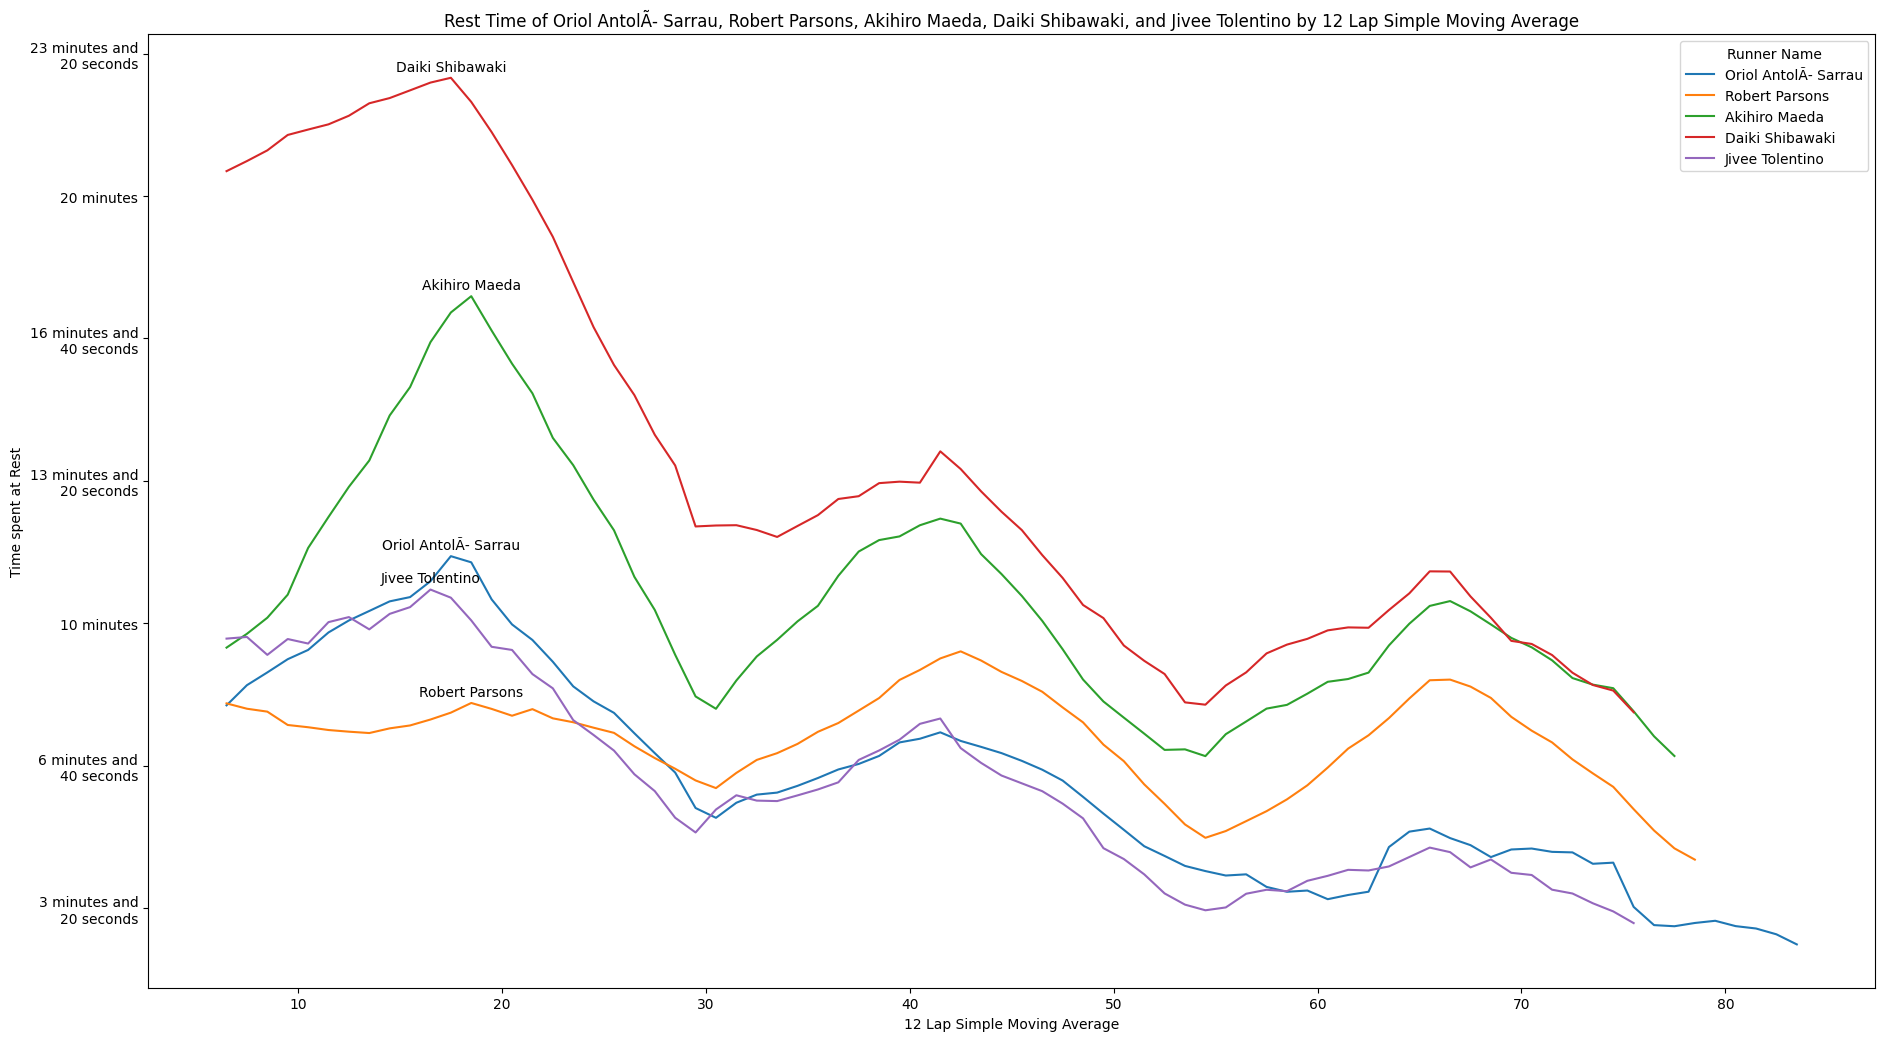

In [15]:

# max_lap = int(homepage_df.Laps.max())
# match_series = (homepage_df.Laps == max_lap)#[match_series]
runner_names_list = homepage_df.sort_values(['Laps', 'Slow Loop'], ascending=[False, True]).iloc[9:14].Name.tolist()
show_rolling_rest_time_line_plot(rest_times_df, runner_names_list, window_int=12, peaks_count=3, verbose=False)

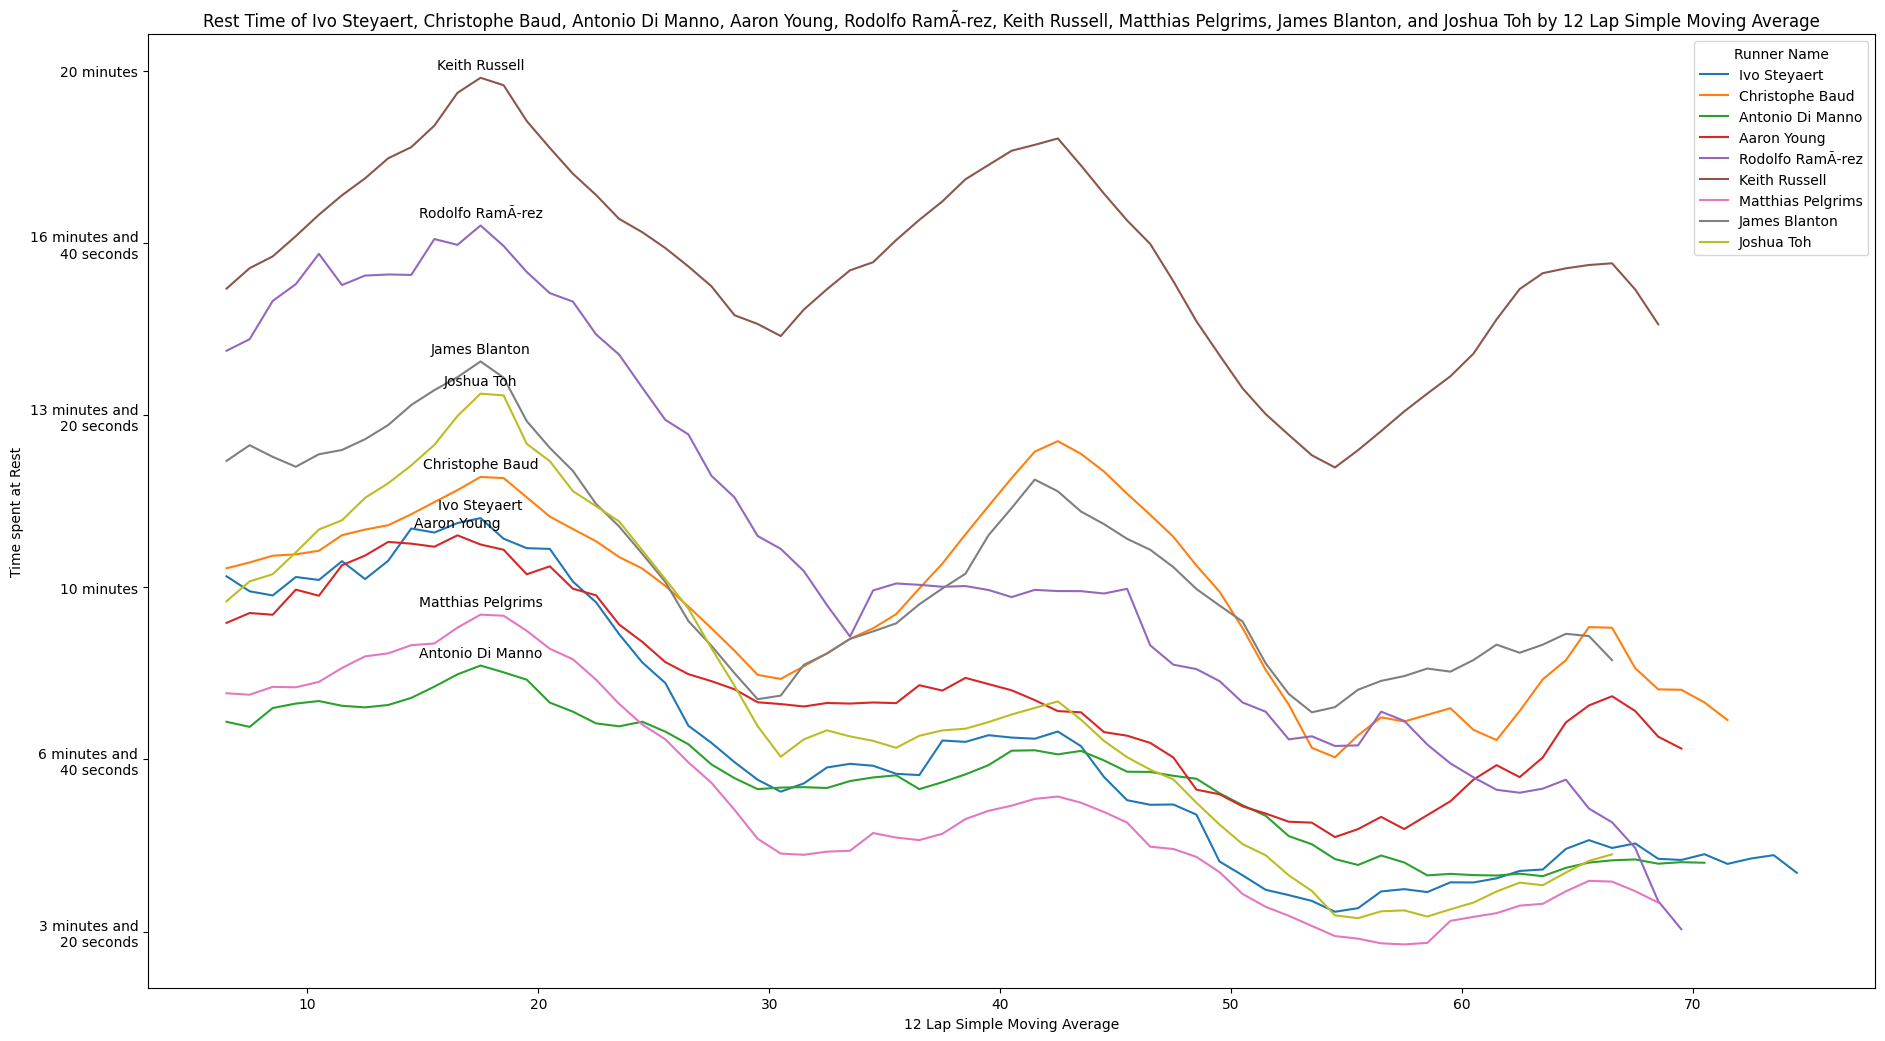

In [16]:

# max_lap = int(homepage_df.Laps.max())
# match_series = (homepage_df.Laps == max_lap)#[match_series]
runner_names_list = homepage_df.sort_values(['Laps', 'Slow Loop'], ascending=[False, True]).iloc[14:23].Name.tolist()
show_rolling_rest_time_line_plot(rest_times_df, runner_names_list, window_int=12, peaks_count=3, verbose=False)

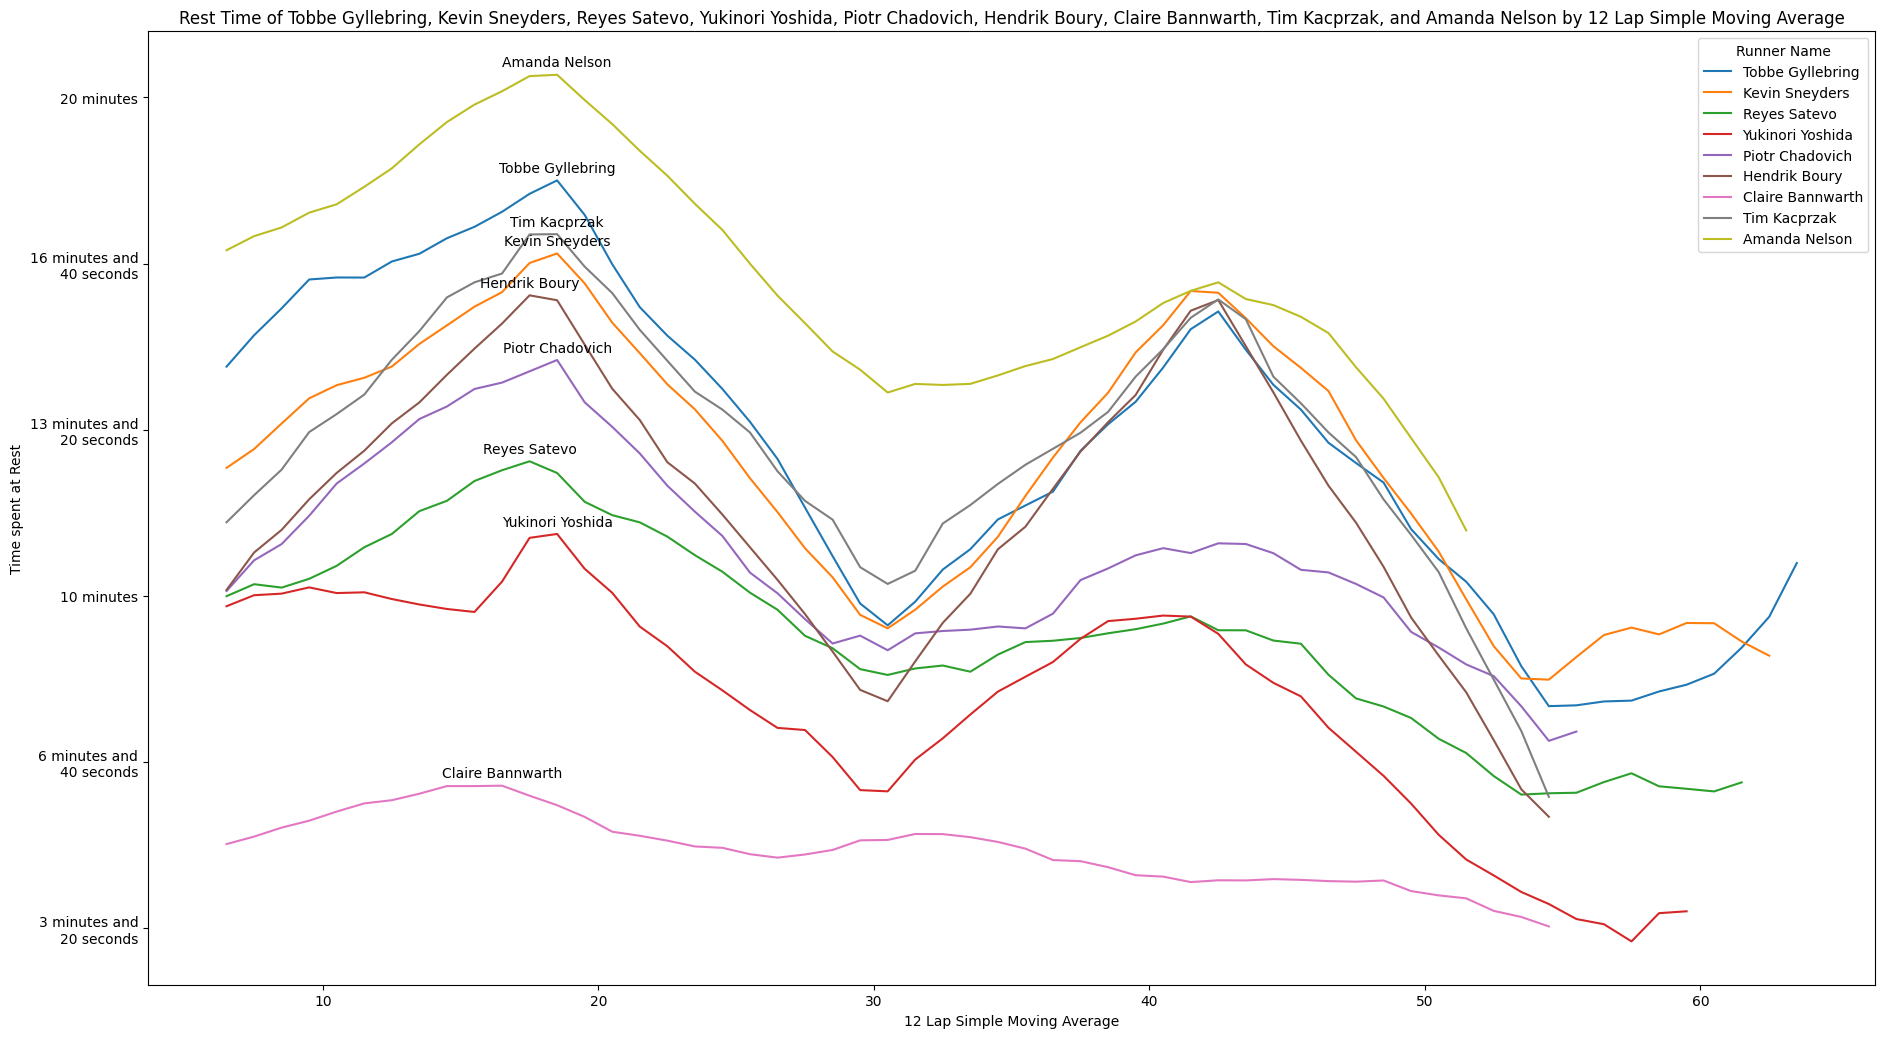

In [17]:

# max_lap = int(homepage_df.Laps.max())
# match_series = (homepage_df.Laps == max_lap)#[match_series]
runner_names_list = homepage_df.sort_values(['Laps', 'Slow Loop'], ascending=[False, True]).iloc[23:32].Name.tolist()
show_rolling_rest_time_line_plot(rest_times_df, runner_names_list, window_int=12, peaks_count=2, verbose=False)

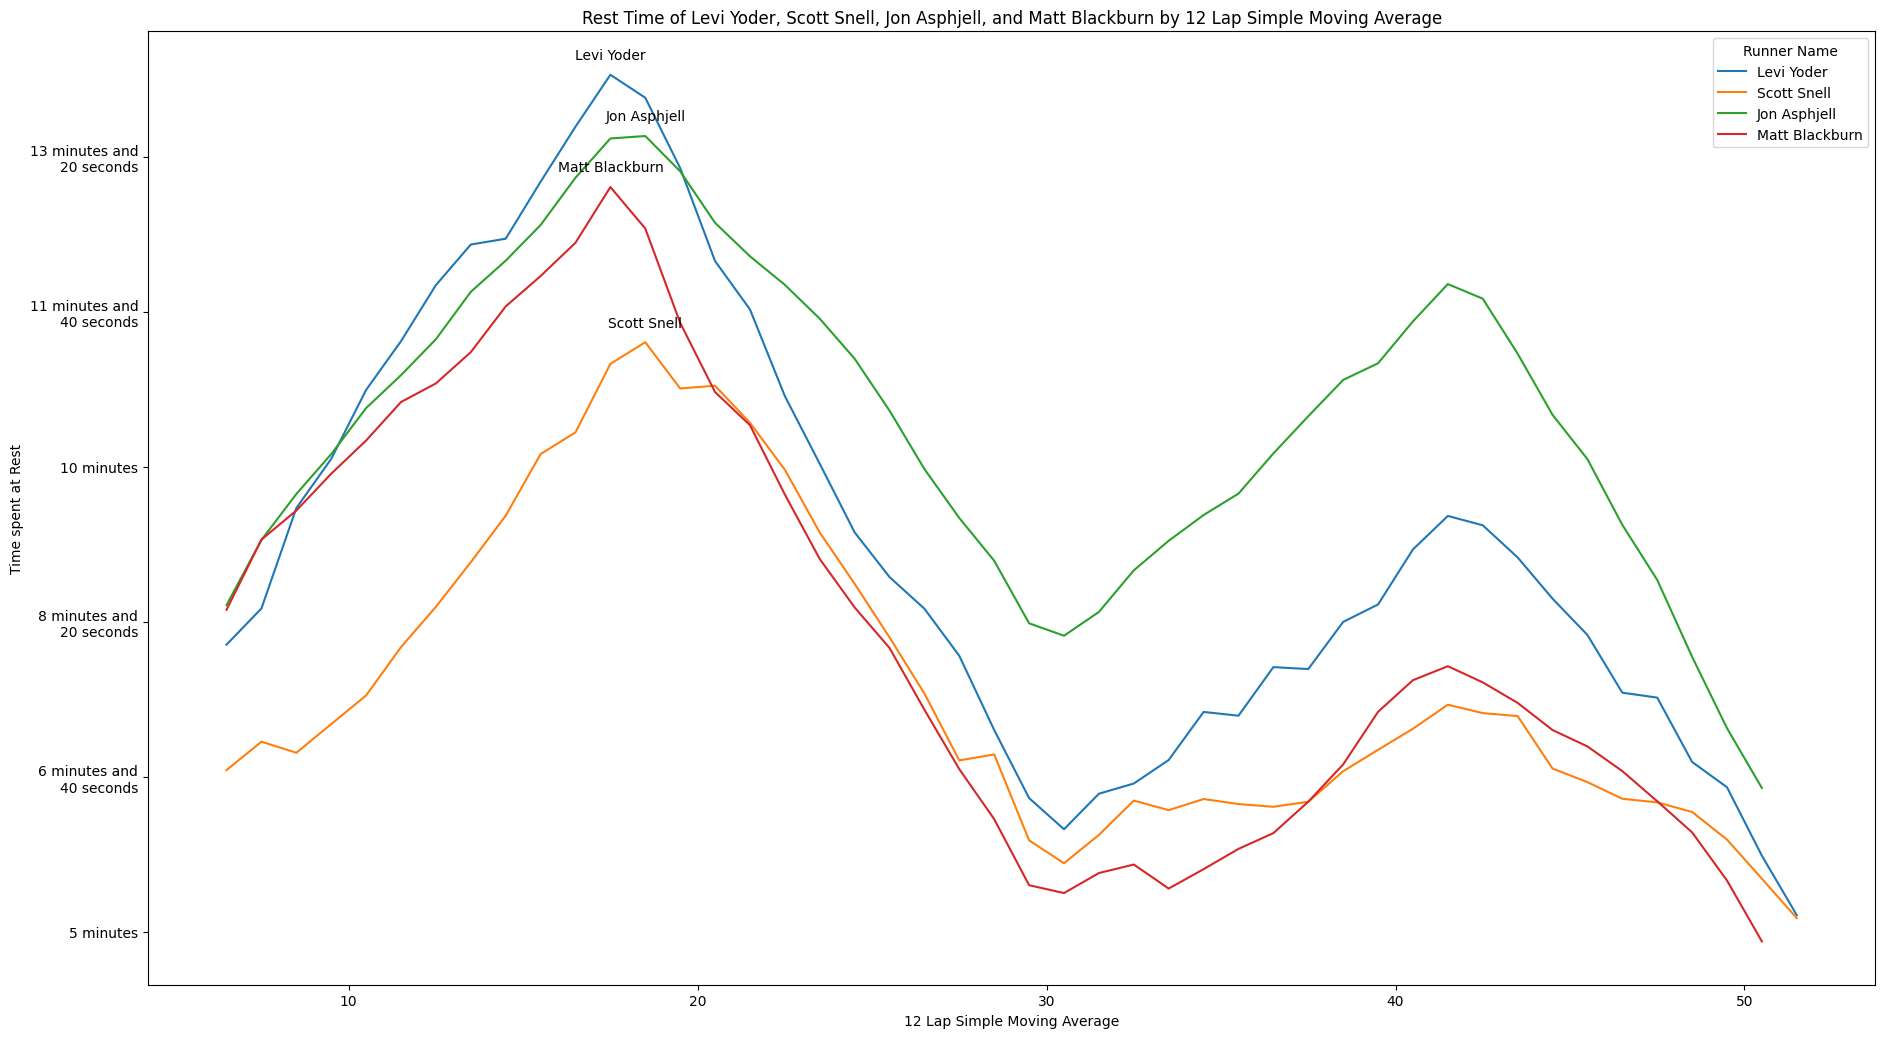

In [18]:

# max_lap = int(homepage_df.Laps.max())
# match_series = (homepage_df.Laps == max_lap)#[match_series]
runner_names_list = homepage_df.sort_values(['Laps', 'Slow Loop'], ascending=[False, True]).iloc[32:36].Name.tolist()
show_rolling_rest_time_line_plot(rest_times_df, runner_names_list, window_int=12, peaks_count=2, verbose=False)

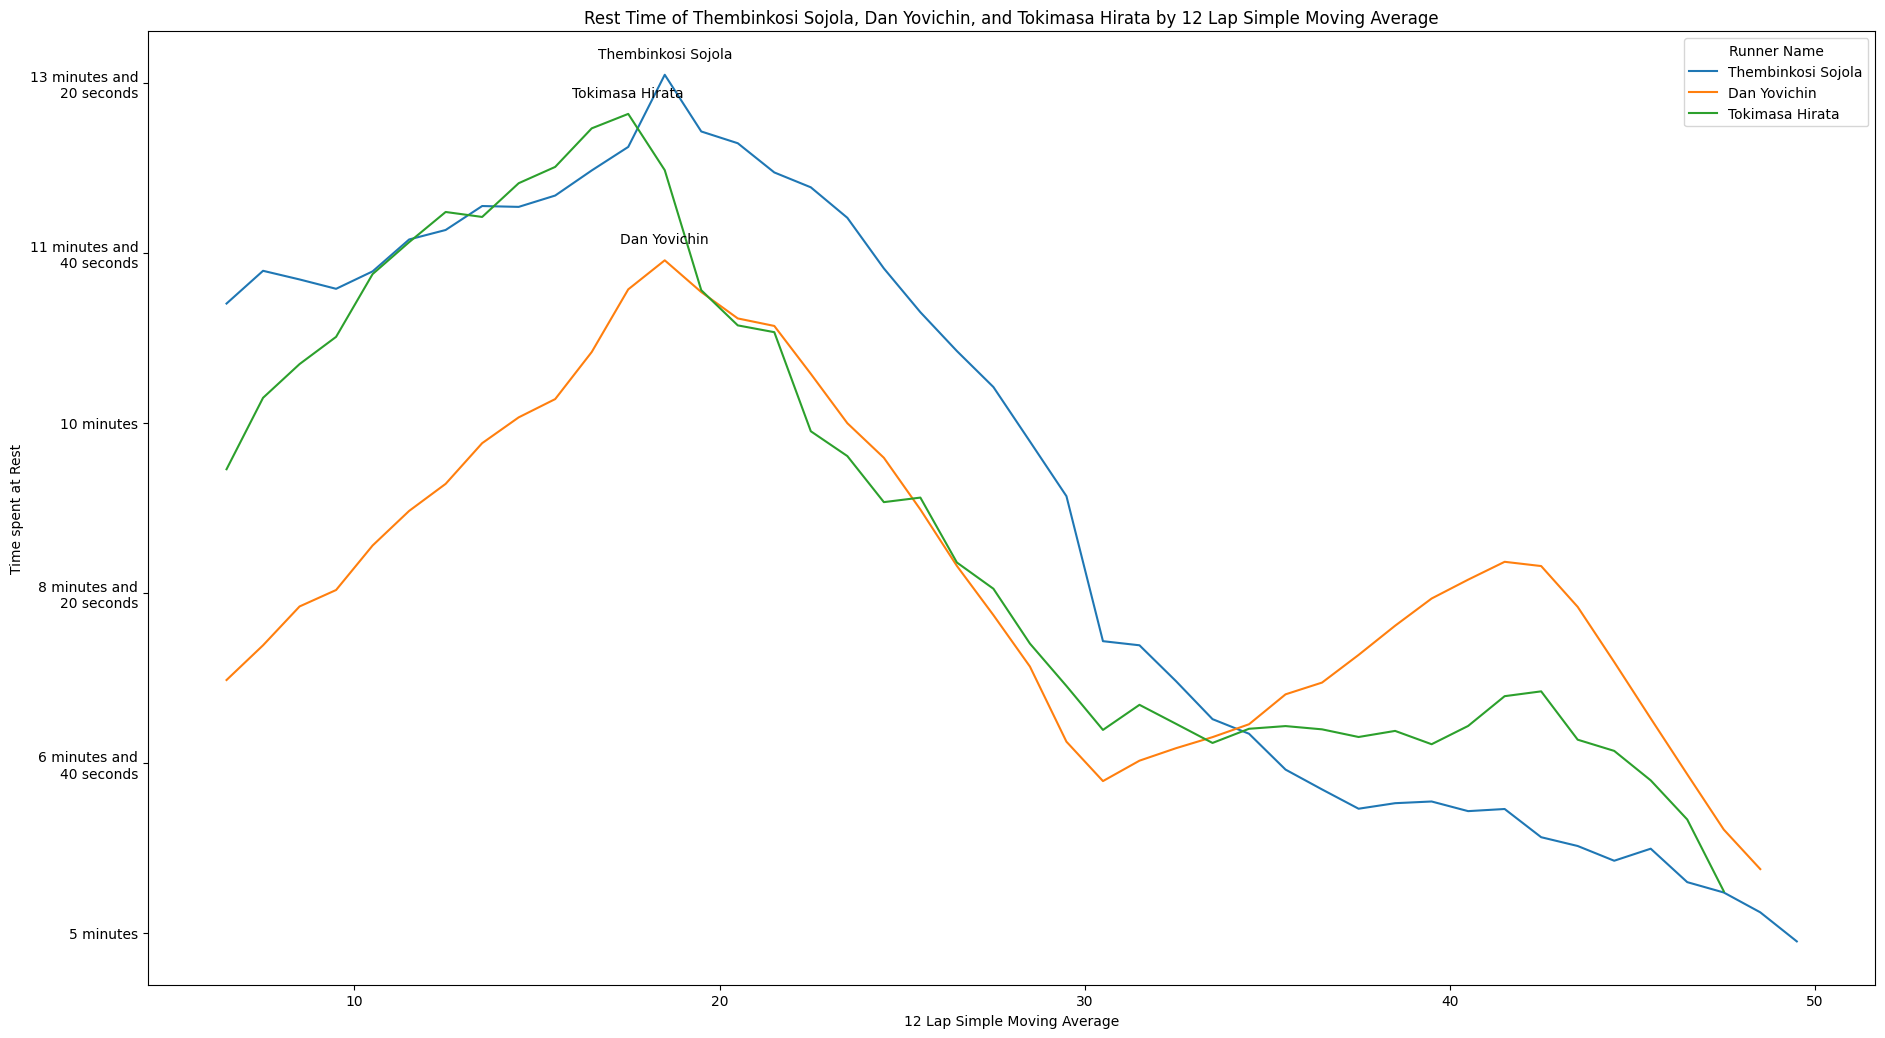

In [19]:

# max_lap = int(homepage_df.Laps.max())
# match_series = (homepage_df.Laps == max_lap)#[match_series]
runner_names_list = homepage_df.sort_values(['Laps', 'Slow Loop'], ascending=[False, True]).iloc[36:39].Name.tolist()
show_rolling_rest_time_line_plot(rest_times_df, runner_names_list, window_int=12, peaks_count=2, verbose=False)

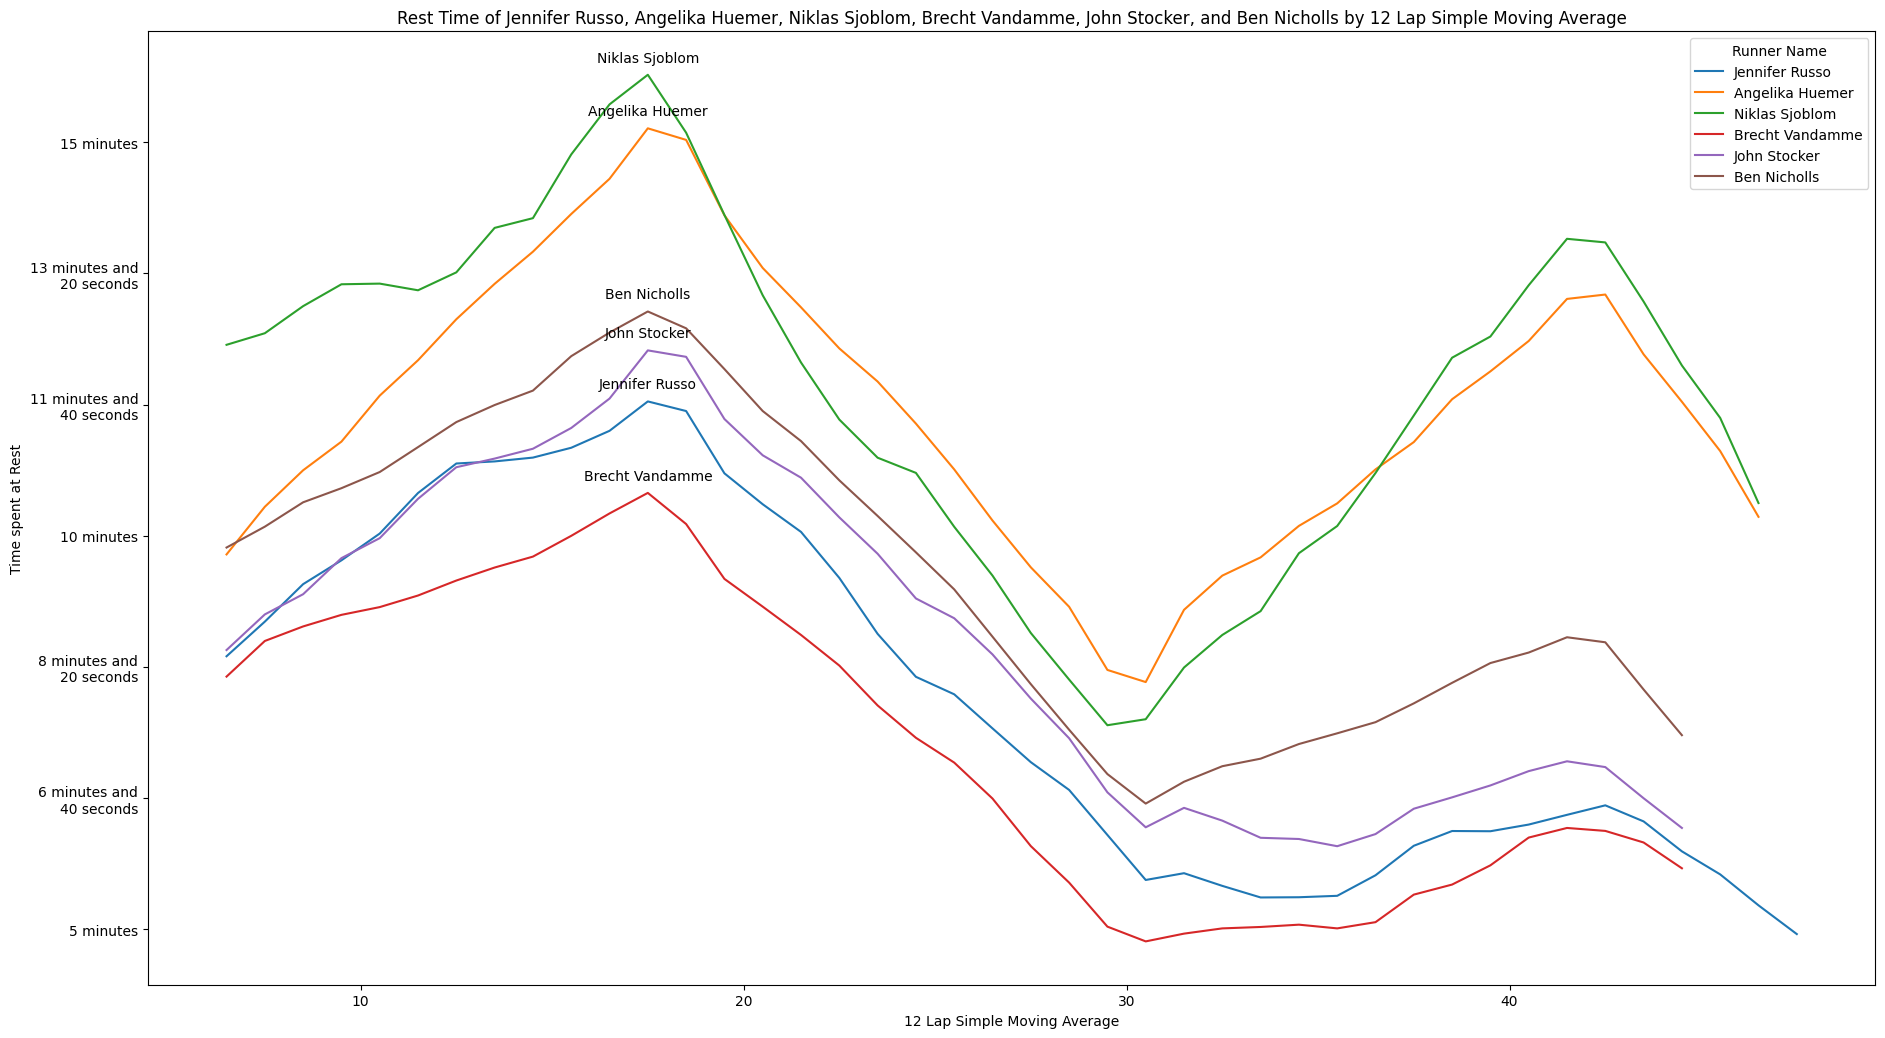

In [20]:

# max_lap = int(homepage_df.Laps.max())
# match_series = (homepage_df.Laps == max_lap)#[match_series]
runner_names_list = homepage_df.sort_values(['Laps', 'Slow Loop'], ascending=[False, True]).iloc[39:45].Name.tolist()
show_rolling_rest_time_line_plot(rest_times_df, runner_names_list, window_int=12, peaks_count=2, verbose=False)

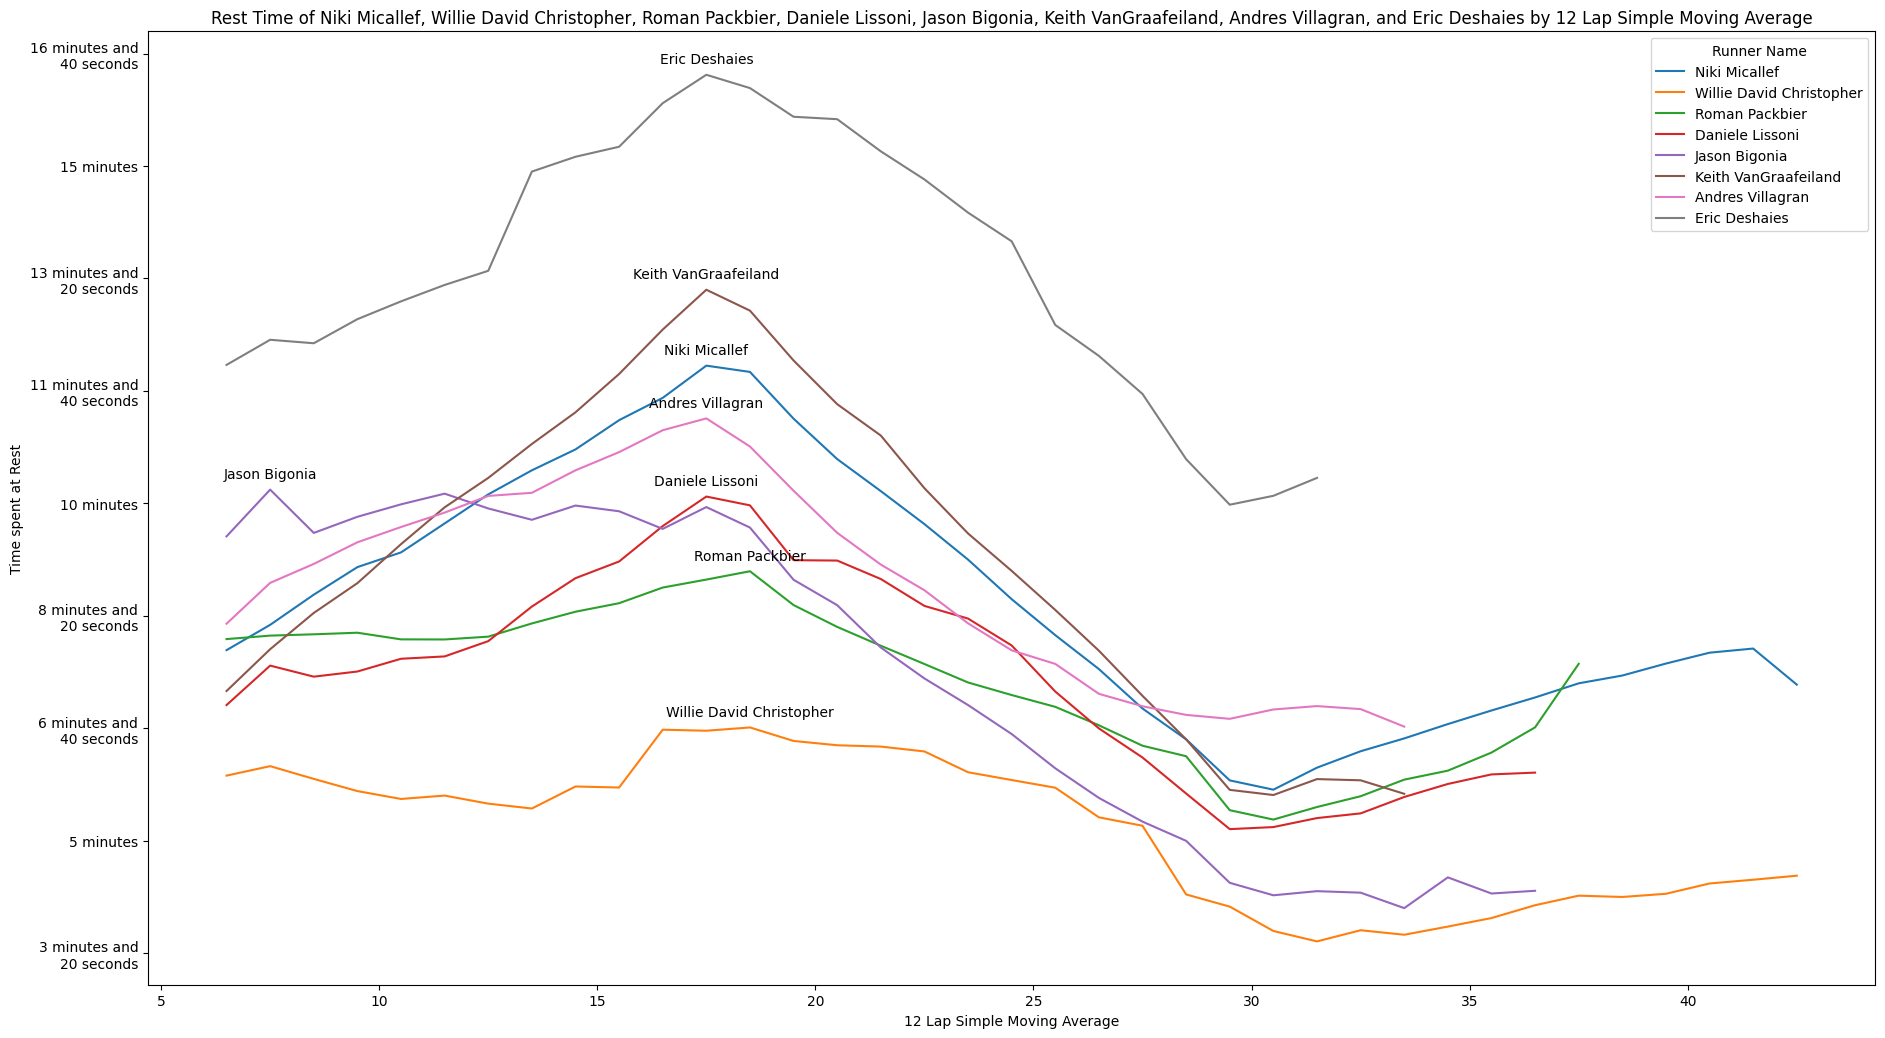

In [21]:

# max_lap = int(homepage_df.Laps.max())
# match_series = (homepage_df.Laps == max_lap)#[match_series]
runner_names_list = homepage_df.sort_values(['Laps', 'Slow Loop'], ascending=[False, True]).iloc[45:53].Name.tolist()
show_rolling_rest_time_line_plot(rest_times_df, runner_names_list, window_int=12, peaks_count=1, verbose=False)

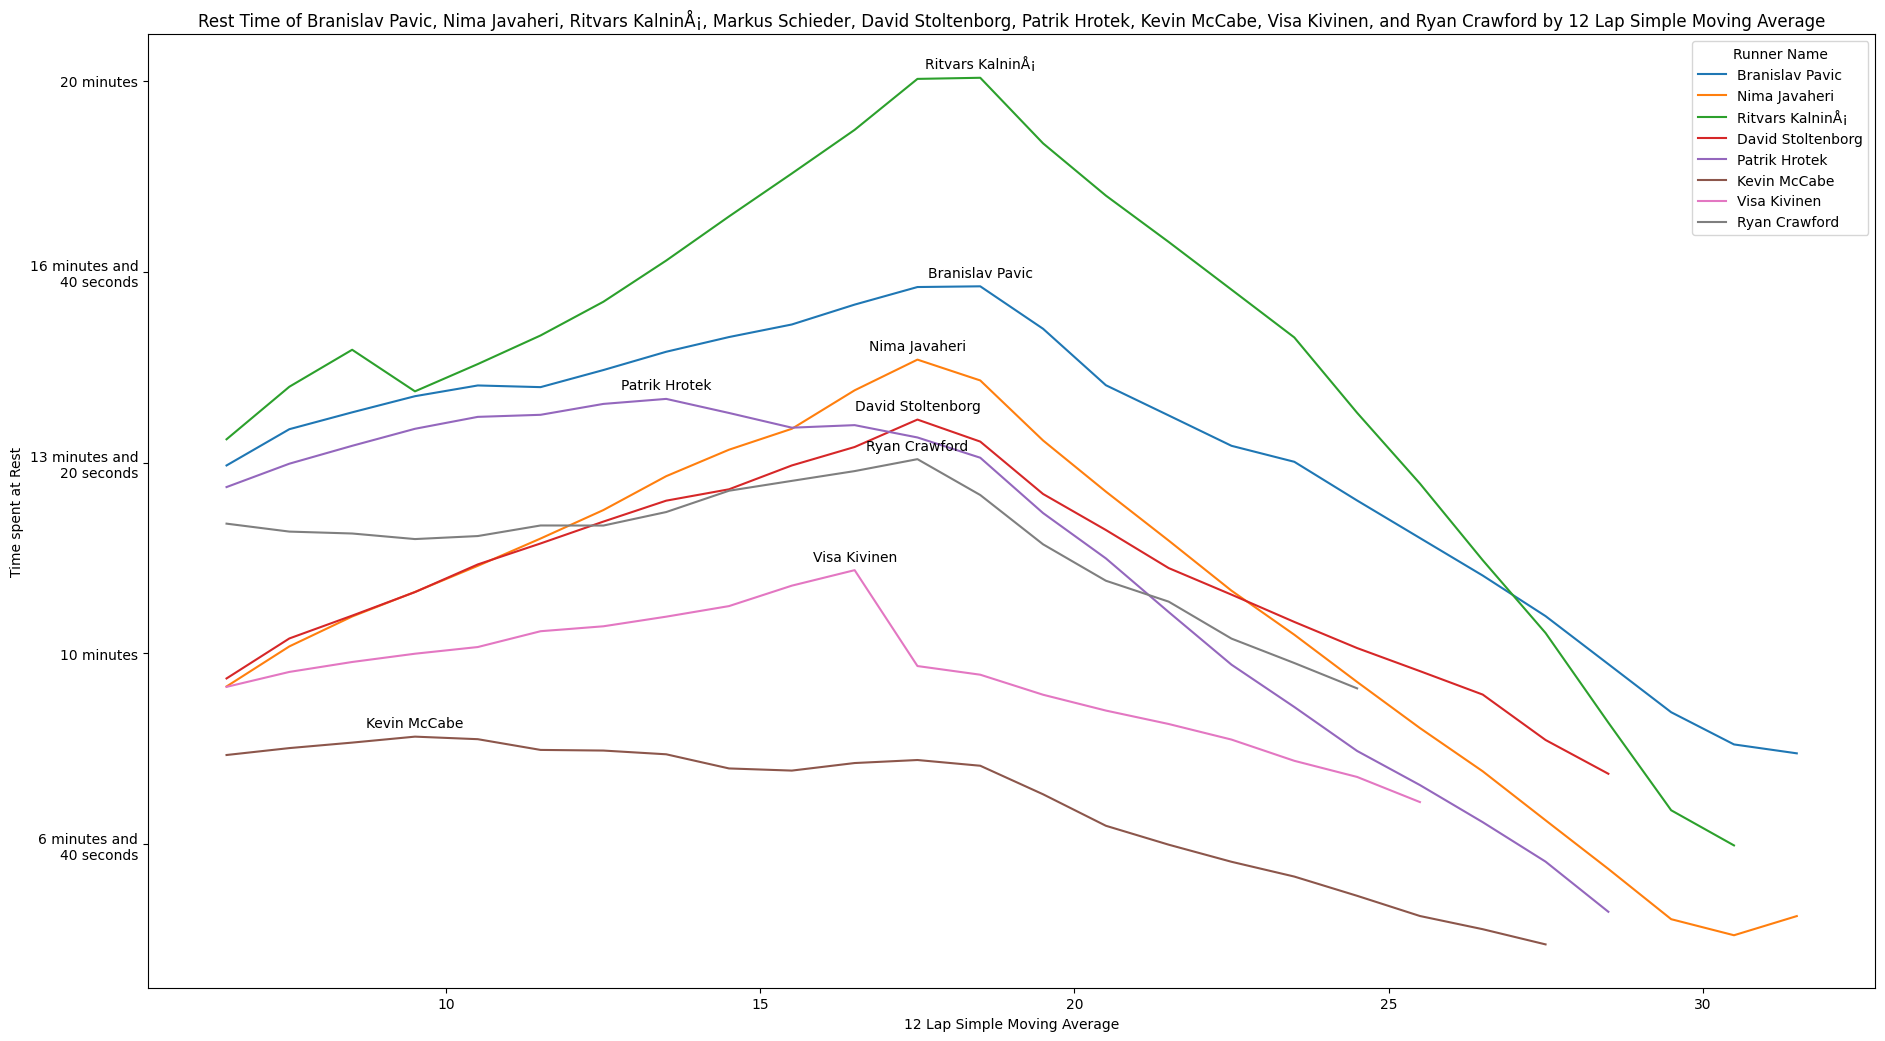

In [22]:

# max_lap = int(homepage_df.Laps.max())
# match_series = (homepage_df.Laps == max_lap)#[match_series]
runner_names_list = homepage_df.sort_values(['Laps', 'Slow Loop'], ascending=[False, True]).iloc[53:62].Name.tolist()
show_rolling_rest_time_line_plot(rest_times_df, runner_names_list, window_int=12, peaks_count=1, verbose=False)

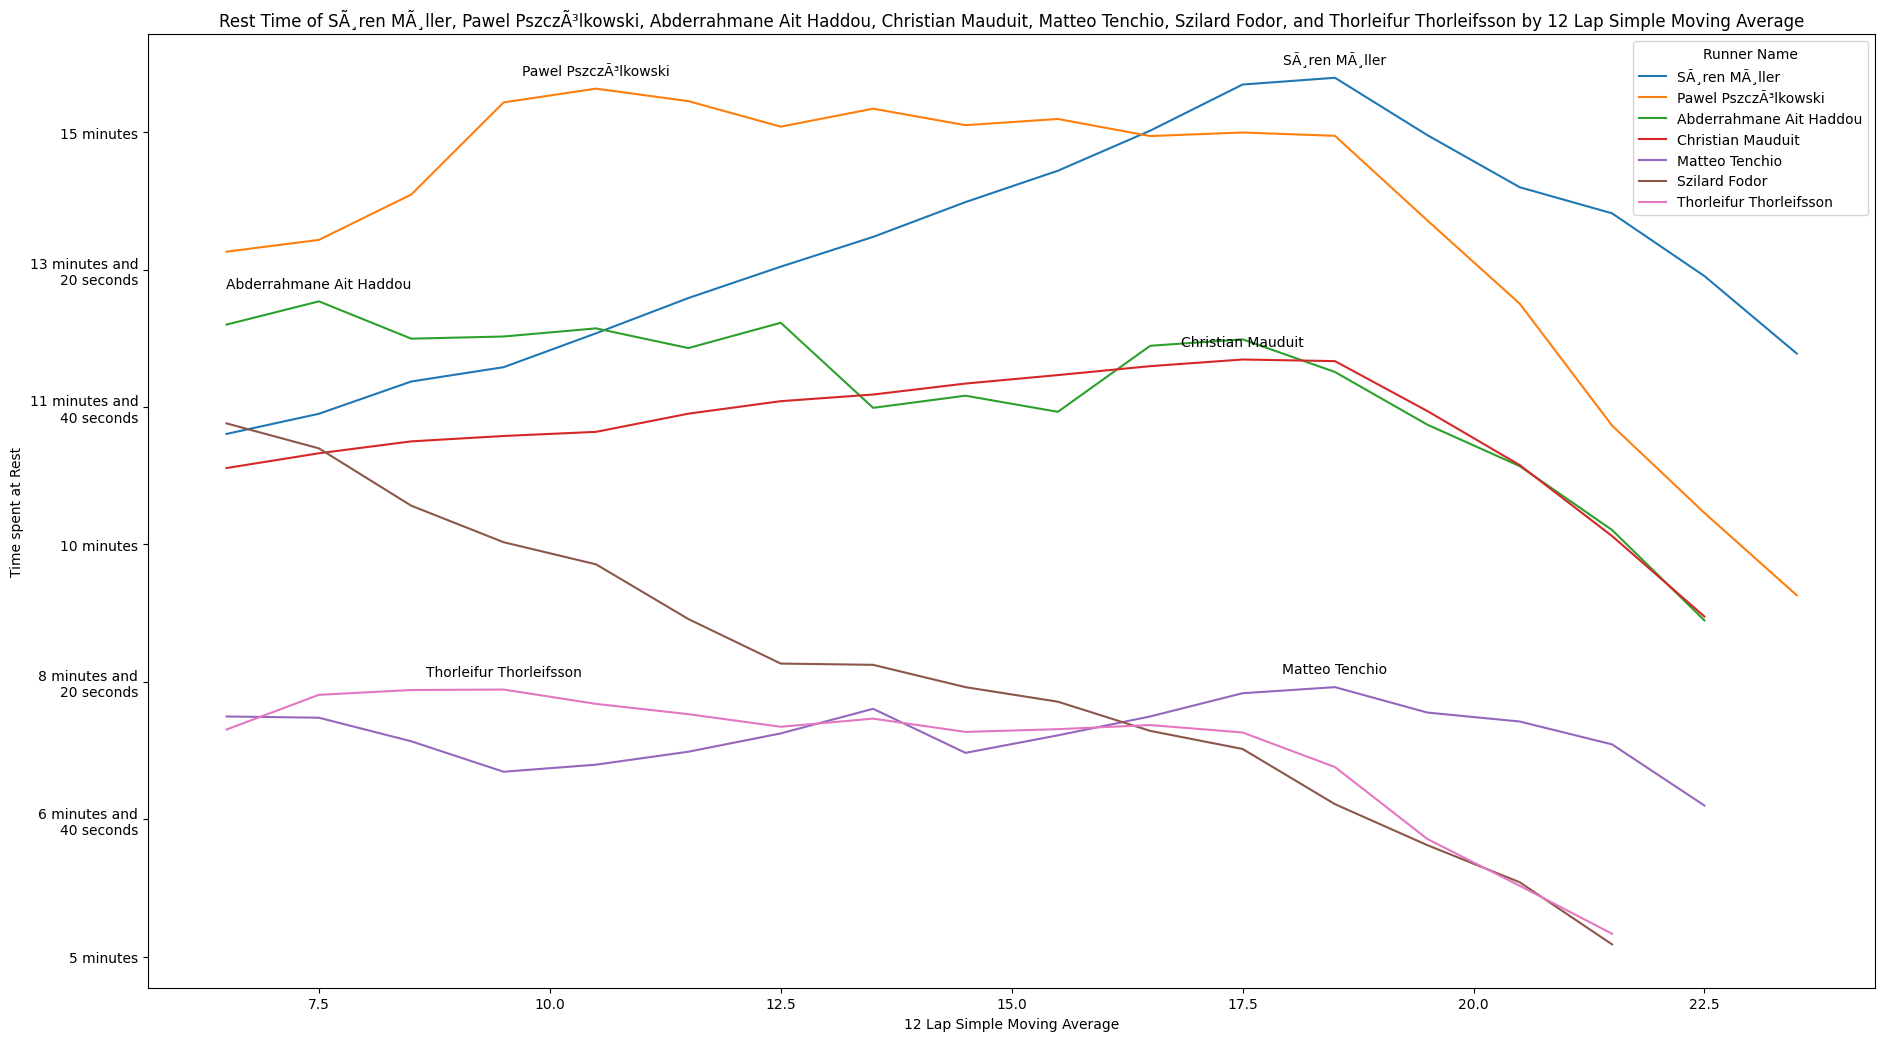

In [23]:

# max_lap = int(homepage_df.Laps.max())
# match_series = (homepage_df.Laps == max_lap)#[match_series]
runner_names_list = homepage_df.sort_values(['Laps', 'Slow Loop'], ascending=[False, True]).iloc[62:69].Name.tolist()
show_rolling_rest_time_line_plot(rest_times_df, runner_names_list, window_int=12, peaks_count=1, verbose=False)

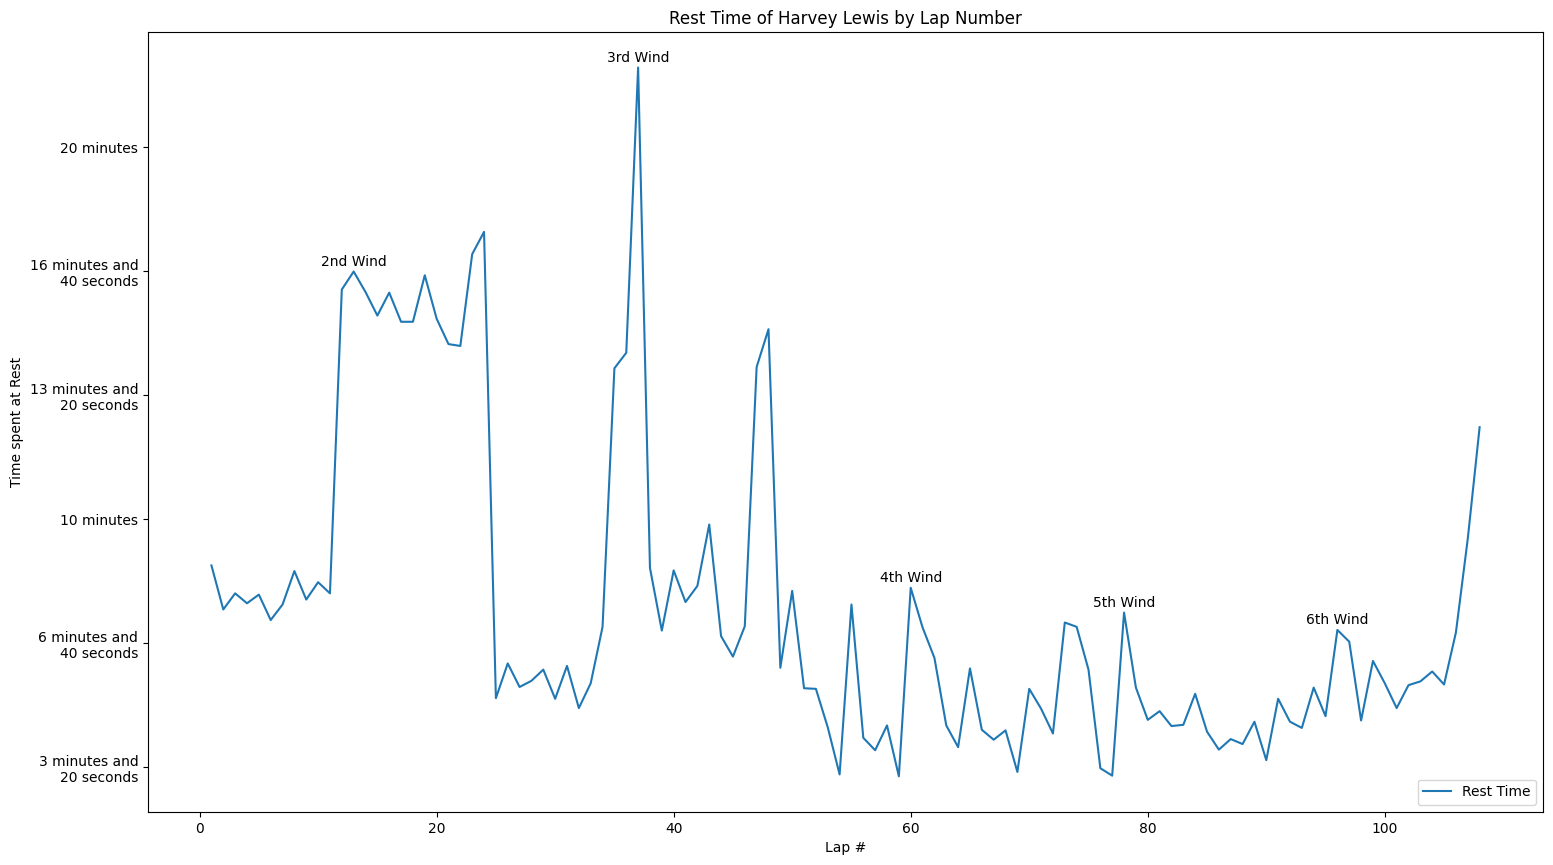

In [24]:

show_rest_time_line_plot(rest_times_df, 'Harvey Lewis', peaks_count=6, verbose=False)